Rocca-S Real Datasets {MAWI, 5G-youtube, urrlc, mixed}

{'Mawi-Dataset-1_1010_3.9G': {'1_0': 9.82924179329299, '3_1': 11.834345449272549, '6_2': 11.67309214245756}, 'merged_packets_with_flow': {'1_0': 0.4195132761020946, '3_1': 0.3536470366013803, '6_2': 0.2763803663370314}, 'clipped_4k_urllc_avg_615_8.83G_1.6': {'1_0': 7.267980898993973, '3_1': 8.343908681305999, '6_2': 7.594739650813655}, 'clipped_8k_mmtc_avg_854_12G_1.6': {'1_0': 8.879274976502293, '3_1': 10.322706529911729, '6_2': 9.48996971204737}}


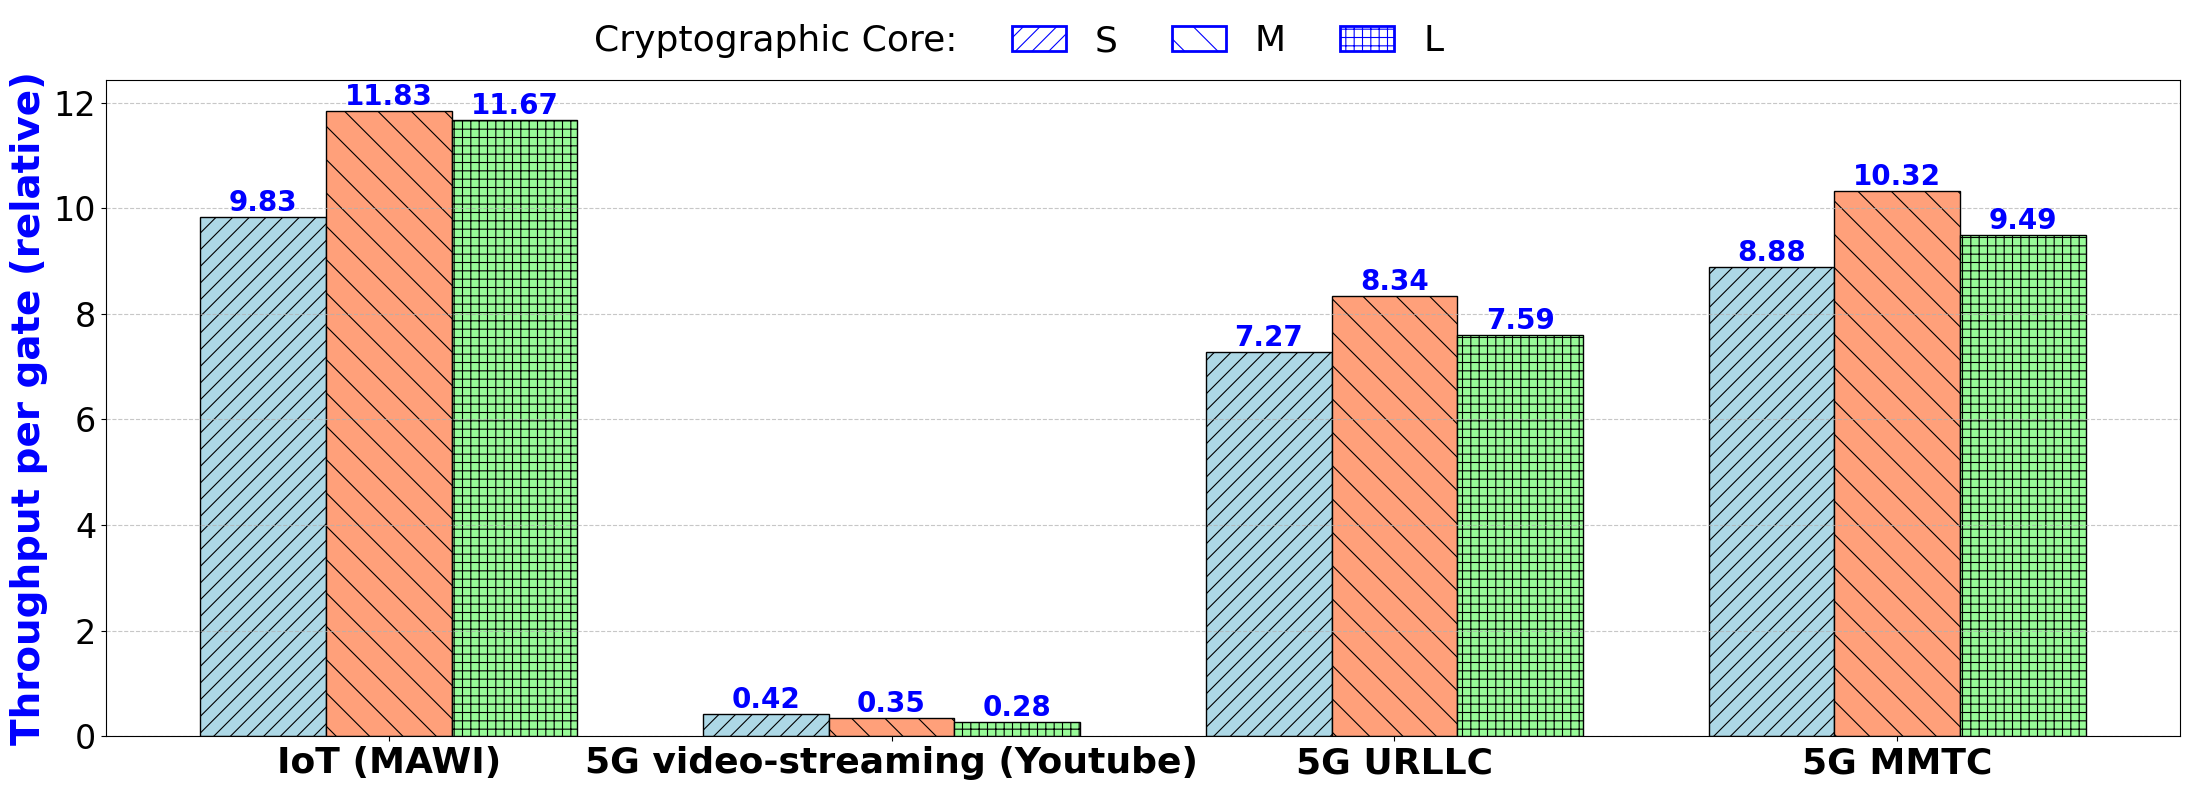

{'1_0_0': 8.879274976502293, '3_1_0': 10.322706529911729, '6_2_0': 9.48996971204737}
{'1_0_0': 0.4129744508587325, '3_1_0': 0.5512817930501467, '6_2_0': 0.6306608922262267}


In [5]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch


# ----- 1. Core‑specific gate‑equivalent and power numbers -----
core_info = {
    '1_0': {'GE': 203760.00, 'Power': 4.381},
    '3_1': {'GE': 241710.00, 'Power': 4.526},
    '6_2': {'GE': 309284.00, 'Power': 4.654}
}

# ----- 2. Visual style (taken from the original script) -----
# colors  = ['#F4C7AB', '#BFD8B8', '#D7CFE4']  # pastel palette
# hatches = ['//', '\\', 'xx']
colors = ['lightblue', 'lightsalmon', 'palegreen']
hatches = ['//', '\\', '++']                # distinctive hatch per bar
labels = ['S','M','L']

plt.rcParams['hatch.linewidth'] = 0.8         # subtle hatch density


# ----- 3. Paths -----
CSV_FOLDER   = 'updated_csvs'
OUTPUT_DIR   = os.path.join(CSV_FOLDER, 'crypto_efficiency_plots')
os.makedirs(OUTPUT_DIR, exist_ok=True)



# ----- 4. Helper to aggregate numbers from every CSV -----
def collect_all_metrics():
    """Return 3 nested dicts keyed by  filename ➜ core ➜ metric."""
    resource_eff, power_eff, throughputs = {}, {}, {}
    throughput_ge_dict = {}
    throughput_watt_dict = {}
    processing_data_dict = {}

    csv_files  = glob.glob(os.path.join(CSV_FOLDER, '*.csv'))
    filenames  = [os.path.splitext(os.path.basename(f))[0] for f in csv_files]

    for path, name in zip(csv_files, filenames):
        df          = pd.read_csv(path)

        first_rows = pd.read_csv(path, nrows=2)
        lengths_col = None  # default column name for lengths
        for c in ["Length (Bytes)", "Length (bytes)", "Length"]:
            if c in first_rows.columns:
                lengths_col = c
                break

        total_bits  = df[lengths_col].sum() * 8

        res, pwr, thr, processing_delay_data = {}, {}, {}, {}
        
        
        for core, spec in core_info.items():
            if core not in df.columns:
                continue          # skip if core column absent

            total_latency      = df[core].max() - df['Time'].min()  # Seconds
            latency_list = df[core].tolist()  # List of latencies for each packet
            relative_time_list = df['Time'].tolist()  # List of relative times for each packet
            # Processing delay :
            processing_delay_list = []
            for i in range(0, len(latency_list)):
                processing_delay_list.append(latency_list[i] - relative_time_list[i])

            
            throughput_bits_seconds = total_bits / total_latency

            thr[core] = throughput_bits_seconds
            res[core] = throughput_bits_seconds / spec['GE']
            pwr[core] = throughput_bits_seconds / spec['Power']
            processing_delay_data[core] = processing_delay_list
        

        # ----- normalise efficiencies to the baseline (core 1_0 = 1) -----
        baseline_res = res['1_0']
        baseline_pwr = pwr['1_0']

        # resource_eff[name] = {k: v / baseline_res for k, v in res.items()}
        # power_eff[name]    = {k: v / baseline_pwr for k, v in pwr.items()}
        # throughputs[name]  = thr

        # Change it to kbps
        throughput_ge_dict[name] = {k: v/ 1000  for k, v in res.items()}  # kilobits per second
        throughput_watt_dict[name]    = {k: v / 1000_000_000   for k, v in pwr.items()} # Gigabits
        throughputs[name]  = thr
        processing_data_dict[name] = processing_delay_data

        # resource_eff[name] = {k: v for k, v in res.items()}
        # power_eff[name]    = {k: v for k, v in pwr.items()}
        # throughputs[name]  = thr

    # return filenames, resource_eff, power_eff, throughputs
    # return filenames, res, pwr, thr
    return filenames, throughput_ge_dict, throughput_watt_dict, throughputs, processing_data_dict




# ----- 5. Plotting helper -----
def make_grouped_bar(data_dict, filenames, title, ylabel, out_name, annotate=False):
    bar_width     = 0.25
    core_labels   = list(core_info.keys())
    indices       = np.arange(len(filenames))

    plt.figure(figsize=(22, 8))

    x_labels = ['IoT (MAWI)', '5G video-streaming (Youtube)', '5G URLLC', '5G MMTC']
    legends = ['Cryptographic Core:','S', 'M', 'L']

    for i, core in enumerate(core_labels):
        vals = [data_dict[file][core] for file in filenames]
        bars = plt.bar(
            indices + i * bar_width,
            vals,
            bar_width,
            color=colors[i],
            edgecolor='black',
            linewidth=1,
            hatch=hatches[i],
            label=core,
        )
        if annotate:
            for bar in bars:
                height = bar.get_height()
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    f'{height:.2f}',
                    ha='center',
                    va='bottom',
                    fontsize=20,
                    rotation=0,
                    color = 'blue',
                    fontweight='bold'

                )

    # plt.xlabel('5G Datasets',fontsize=20,fontweight='bold')
    plt.ylabel(ylabel, fontsize=28, fontweight='bold', color='blue')
    plt.title(title,fontsize=28)
    plt.xticks(indices + bar_width * (len(core_labels) - 1) / 2,
               x_labels, ha='center', fontsize=26, fontweight='bold')

    legend_elems = [
        Rectangle((0, 0), 1, 1, facecolor=colors[i],
                  edgecolor='black', linewidth=1, alpha=0.8, hatch=hatches[i])
        for i in range(len(labels))
    ]
    # plt.legend(legend_elems, labels, title='Core')
    # plt.legend(
    # legend_elems,
    # labels,
    # title='cryptographic core',
    # fontsize=16,          # size of the legend labels
    # title_fontsize=16     # size of the legend title
    # )
    legend_labels = ['Cryptographic Core:', 'S', 'M', 'L']
    legend_handles = [
        Patch(facecolor='white', edgecolor='white'),  # blank patch for label
        Patch(facecolor=colors[0], edgecolor='blue', hatch=hatches[0], fill=False, linewidth=2),
        Patch(facecolor=colors[1], edgecolor='blue', hatch=hatches[1],fill=False, linewidth=2),
        Patch(facecolor=colors[2], edgecolor='blue', hatch=hatches[2],fill=False, linewidth=2),
    ]

    plt.legend(
        legend_handles,
        legend_labels,
        loc='lower center',
        bbox_to_anchor=(0.42, 1.0),
        ncol=4,
        frameon=False,
        fontsize=26,
        handlelength=1.5,
        columnspacing=1.5,
        borderaxespad=0.2,
    )

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tick_params(axis='y', labelsize=24)
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(OUTPUT_DIR, out_name), dpi=300)
    plt.close()


# ----- 6. Main -----
if __name__ == '__main__':
    fnames, res_eff, pwr_eff, thr, processing_data_dict = collect_all_metrics()

    print(res_eff)

    make_grouped_bar(res_eff, fnames,
                    #  'Resource Efficiency',
                        None,
                     'Throughput per gate (relative)',
                     'normalized_resource_eff.png',
                     annotate=True)

    # make_grouped_bar(pwr_eff, fnames,
    #                 #  'Power Efficiency',
    #                  None,
    #                  'Power Efficiency',
    #                  'normalized_power_eff.png')

    # make_grouped_bar(thr, fnames,
    #                  'Raw Throughput Comparison',
    #                  'Throughput (bits/ms)',
    #                  'throughput.png')

    # print('Plots saved to:', OUTPUT_DIR)

    # labels = ['1_0_0', '3_1_0', '6_2_0', '1_0_1', '3_1_1', '6_2_1']
    labels = ['1_0_0', '3_1_0', '6_2_0']
    k=0
    z=0
    v=0

    # dataset_choose = ['merged_packets_with_flow', 'clipped_8k_mmtc_avg_854_12G_1.6']
    dataset_choose = ['clipped_8k_mmtc_avg_854_12G_1.6']

    throughput_ge_dict = {}
    throughput_watt_dict = {}
    processing_data = {}

    # for file in fnames:
    #     if file not in dataset_choose:
    #         continue

    #     temp_1 = res_eff[file] # dictionary
    #     for key,value in temp_1.items():
    #         if labels[k] not in throughput_ge_dict:
    #             throughput_ge_dict[labels[k]] = value
    #             k+=1
        
    #     temp2 = pwr_eff[file] # dictionary
    #     for key,value in temp2.items():
    #         if labels[z] not in throughput_watt_dict:
    #             throughput_watt_dict[labels[z]] = value
    #             z+=1
        
    #     temp3 = processing_data_dict[file]
    #     for key, value in temp3.items():
    #         if labels[v] not in processing_data:
    #             processing_data[labels[v]] = value
    #             v+=1

    temp_mmtc = res_eff['clipped_8k_mmtc_avg_854_12G_1.6']
    for key, value in temp_mmtc.items():
        if labels[k] not in throughput_ge_dict:
            throughput_ge_dict[labels[k]] = value
            k += 1
        if labels[z] not in throughput_watt_dict:
            throughput_watt_dict[labels[z]] = pwr_eff['clipped_8k_mmtc_avg_854_12G_1.6'][key]
            z += 1
        if labels[v] not in processing_data:
            processing_data[labels[v]] = processing_data_dict['clipped_8k_mmtc_avg_854_12G_1.6'][key]
            v += 1
    
    print(throughput_ge_dict)
    print(throughput_watt_dict)
    # print(processing_data['1_0_0'])



Now calculate the relative throughput with respect to baseline 1x

{'Mawi-Dataset-1_1010_3.9G': {'1_0': 1.0, '3_1': 1.2039937258790143, '6_2': 1.187588258376422}, 'merged_packets_with_flow': {'1_0': 1.0, '3_1': 0.8429936708732791, '6_2': 0.6588119663458998}, 'clipped_4k_urllc_avg_615_8.83G_1.6': {'1_0': 1.0, '3_1': 1.1480366827134831, '6_2': 1.0449586695893642}, 'clipped_8k_mmtc_avg_854_12G_1.6': {'1_0': 1.0, '3_1': 1.162561871011909, '6_2': 1.0687775451443042}}


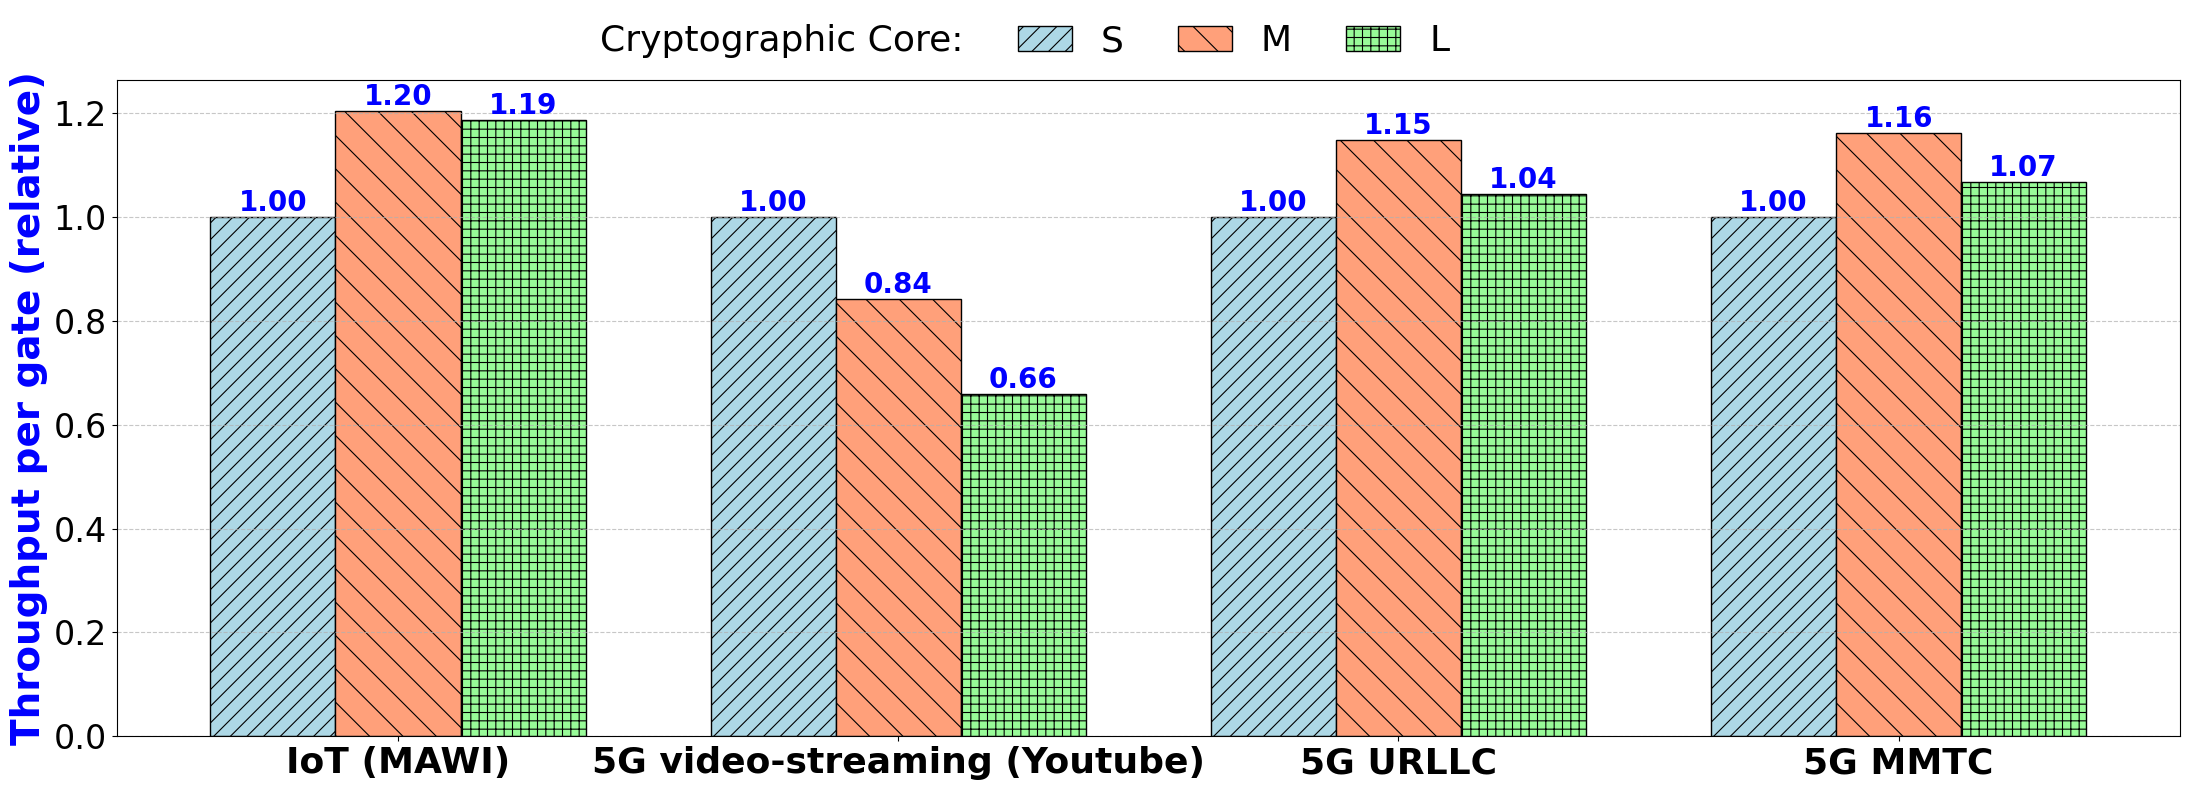

{'1_0_0': 1.0, '3_1_0': 1.162561871011909, '6_2_0': 1.0687775451443042}
{'1_0_0': 1.0, '3_1_0': 1.3349053238131805, '6_2_0': 1.52711842322168}


In [4]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch


# ----- 1. Core‑specific gate‑equivalent and power numbers -----
core_info = {
    '1_0': {'GE': 203760.00, 'Power': 4.381},
    '3_1': {'GE': 241710.00, 'Power': 4.526},
    '6_2': {'GE': 309284.00, 'Power': 4.654}
}

# ----- 2. Visual style (taken from the original script) -----
# colors  = ['#F4C7AB', '#BFD8B8', '#D7CFE4']  # pastel palette
# hatches = ['//', '\\', 'xx']
colors = ['lightblue', 'lightsalmon', 'palegreen']
hatches = ['//', '\\', '++']                # distinctive hatch per bar
labels = ['S','M','L']

plt.rcParams['hatch.linewidth'] = 0.8         # subtle hatch density


# ----- 3. Paths -----
CSV_FOLDER   = 'updated_csvs'
OUTPUT_DIR   = os.path.join(CSV_FOLDER, 'crypto_efficiency_plots')
os.makedirs(OUTPUT_DIR, exist_ok=True)



# ----- 4. Helper to aggregate numbers from every CSV -----
def collect_all_metrics():
    """Return 3 nested dicts keyed by  filename ➜ core ➜ metric."""
    resource_eff, power_eff, throughputs = {}, {}, {}
    throughput_ge_dict = {}
    throughput_watt_dict = {}
    processing_data_dict = {}

    csv_files  = glob.glob(os.path.join(CSV_FOLDER, '*.csv'))
    filenames  = [os.path.splitext(os.path.basename(f))[0] for f in csv_files]

    for path, name in zip(csv_files, filenames):
        df          = pd.read_csv(path)

        first_rows = pd.read_csv(path, nrows=2)
        lengths_col = None  # default column name for lengths
        for c in ["Length (Bytes)", "Length (bytes)", "Length"]:
            if c in first_rows.columns:
                lengths_col = c
                break

        total_bits  = df[lengths_col].sum() * 8

        res, pwr, thr, processing_delay_data = {}, {}, {}, {}
        
        
        for core, spec in core_info.items():
            if core not in df.columns:
                continue          # skip if core column absent

            total_latency      = df[core].max() - df['Time'].min()  # Seconds
            latency_list = df[core].tolist()  # List of latencies for each packet
            relative_time_list = df['Time'].tolist()  # List of relative times for each packet
            # Processing delay :
            processing_delay_list = []
            for i in range(0, len(latency_list)):
                processing_delay_list.append(latency_list[i] - relative_time_list[i])

            
            throughput_bits_seconds = total_bits / total_latency * 1000 * 1000 #(Mbit/seconds)

            thr[core] = throughput_bits_seconds
            res[core] = throughput_bits_seconds / spec['GE']
            pwr[core] = throughput_bits_seconds / spec['Power']
            processing_delay_data[core] = processing_delay_list
        

        # ----- normalise efficiencies to the baseline (core 1_0 = 1) -----
        baseline_res = res['1_0']
        baseline_pwr = pwr['1_0']

        # resource_eff[name] = {k: v / baseline_res for k, v in res.items()}
        # power_eff[name]    = {k: v / baseline_pwr for k, v in pwr.items()}
        # throughputs[name]  = thr

        # Change it to kbps
        throughput_ge_dict[name] = {k: v/ baseline_res   for k, v in res.items()}  # kilobits per second
        throughput_watt_dict[name]    = {k: v /baseline_pwr    for k, v in pwr.items()} # Gigabits
        throughputs[name]  = thr
        processing_data_dict[name] = processing_delay_data

        # resource_eff[name] = {k: v for k, v in res.items()}
        # power_eff[name]    = {k: v for k, v in pwr.items()}
        # throughputs[name]  = thr

    # return filenames, resource_eff, power_eff, throughputs
    # return filenames, res, pwr, thr
    return filenames, throughput_ge_dict, throughput_watt_dict, throughputs, processing_data_dict




# ----- 5. Plotting helper -----
def make_grouped_bar(data_dict, filenames, title, ylabel, out_name, annotate=False):
    bar_width     = 0.25
    core_labels   = list(core_info.keys())
    indices       = np.arange(len(filenames))

    plt.figure(figsize=(22, 8))

    x_labels = ['IoT (MAWI)', '5G video-streaming (Youtube)', '5G URLLC', '5G MMTC']
    legends = ['Cryptographic Core:','S', 'M', 'L']

    for i, core in enumerate(core_labels):
        vals = [data_dict[file][core] for file in filenames]
        bars = plt.bar(
            indices + i * bar_width,
            vals,
            bar_width,
            color=colors[i],
            edgecolor='black',
            linewidth=1,
            hatch=hatches[i],
            label=core,
        )
        if annotate:
            for bar in bars:
                height = bar.get_height()
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    f'{height:.2f}',
                    ha='center',
                    va='bottom',
                    fontsize=20,
                    rotation=0,
                    color = 'blue',
                    fontweight='bold'

                )

    # plt.xlabel('5G Datasets',fontsize=20,fontweight='bold')
    plt.ylabel(ylabel, fontsize=28, fontweight='bold', color='blue')
    plt.title(title,fontsize=28)
    plt.xticks(indices + bar_width * (len(core_labels) - 1) / 2,
               x_labels, ha='center', fontsize=26, fontweight='bold')

    legend_elems = [
        Rectangle((0, 0), 1, 1, facecolor=colors[i],
                  edgecolor='black', linewidth=1, alpha=0.8, hatch=hatches[i])
        for i in range(len(labels))
    ]
    # plt.legend(legend_elems, labels, title='Core')
    # plt.legend(
    # legend_elems,
    # labels,
    # title='cryptographic core',
    # fontsize=16,          # size of the legend labels
    # title_fontsize=16     # size of the legend title
    # )
    legend_labels = ['Cryptographic Core:', 'S', 'M', 'L']
    legend_handles = [
        Patch(facecolor='white', edgecolor='white'),  # blank patch for label
        Patch(facecolor=colors[0], edgecolor='black', hatch=hatches[0]),
        Patch(facecolor=colors[1], edgecolor='black', hatch=hatches[1]),
        Patch(facecolor=colors[2], edgecolor='black', hatch=hatches[2]),
    ]

    plt.legend(
        legend_handles,
        legend_labels,
        loc='lower center',
        bbox_to_anchor=(0.42, 1.0),
        ncol=4,
        frameon=False,
        fontsize=26,
        handlelength=1.5,
        columnspacing=1.5,
        borderaxespad=0.2,
    )

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tick_params(axis='y', labelsize=24)
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(OUTPUT_DIR, out_name), dpi=300)
    plt.close()


# ----- 6. Main -----
if __name__ == '__main__':
    fnames, res_eff, pwr_eff, thr, processing_data_dict = collect_all_metrics()

    print(res_eff)

    make_grouped_bar(res_eff, fnames,
                    #  'Resource Efficiency',
                        None,
                     'Throughput per gate (relative)',
                     'normalized_resource_eff.png',
                     annotate=True)

    # make_grouped_bar(pwr_eff, fnames,
    #                 #  'Power Efficiency',
    #                  None,
    #                  'Power Efficiency',
    #                  'normalized_power_eff.png')

    # make_grouped_bar(thr, fnames,
    #                  'Raw Throughput Comparison',
    #                  'Throughput (bits/ms)',
    #                  'throughput.png')

    # print('Plots saved to:', OUTPUT_DIR)

    # labels = ['1_0_0', '3_1_0', '6_2_0', '1_0_1', '3_1_1', '6_2_1']
    labels = ['1_0_0', '3_1_0', '6_2_0']
    k=0
    z=0
    v=0

    # dataset_choose = ['merged_packets_with_flow', 'clipped_8k_mmtc_avg_854_12G_1.6']
    dataset_choose = ['clipped_8k_mmtc_avg_854_12G_1.6']

    throughput_ge_dict = {}
    throughput_watt_dict = {}
    processing_data = {}

    # for file in fnames:
    #     if file not in dataset_choose:
    #         continue

    #     temp_1 = res_eff[file] # dictionary
    #     for key,value in temp_1.items():
    #         if labels[k] not in throughput_ge_dict:
    #             throughput_ge_dict[labels[k]] = value
    #             k+=1
        
    #     temp2 = pwr_eff[file] # dictionary
    #     for key,value in temp2.items():
    #         if labels[z] not in throughput_watt_dict:
    #             throughput_watt_dict[labels[z]] = value
    #             z+=1
        
    #     temp3 = processing_data_dict[file]
    #     for key, value in temp3.items():
    #         if labels[v] not in processing_data:
    #             processing_data[labels[v]] = value
    #             v+=1

    temp_mmtc = res_eff['clipped_8k_mmtc_avg_854_12G_1.6']
    for key, value in temp_mmtc.items():
        if labels[k] not in throughput_ge_dict:
            throughput_ge_dict[labels[k]] = value
            k += 1
        if labels[z] not in throughput_watt_dict:
            throughput_watt_dict[labels[z]] = pwr_eff['clipped_8k_mmtc_avg_854_12G_1.6'][key]
            z += 1
        if labels[v] not in processing_data:
            processing_data[labels[v]] = processing_data_dict['clipped_8k_mmtc_avg_854_12G_1.6'][key]
            v += 1
    
    print(throughput_ge_dict)
    print(throughput_watt_dict)
    # print(processing_data['1_0_0'])



Redo the above experiment to add Resource efficiency

{'Mawi-Dataset-1_1010_3.9G': {'1_0': 1.0, '3_1': 1.2039937258790143, '6_2': 1.187588258376422}, 'merged_packets_with_flow': {'1_0': 1.0, '3_1': 0.8429936708732791, '6_2': 0.6588119663458998}, 'clipped_4k_urllc_avg_615_8.83G_1.6': {'1_0': 1.0, '3_1': 1.1480366827134831, '6_2': 1.0449586695893642}, 'clipped_8k_mmtc_avg_854_12G_1.6': {'1_0': 1.0, '3_1': 1.162561871011909, '6_2': 1.0687775451443042}}


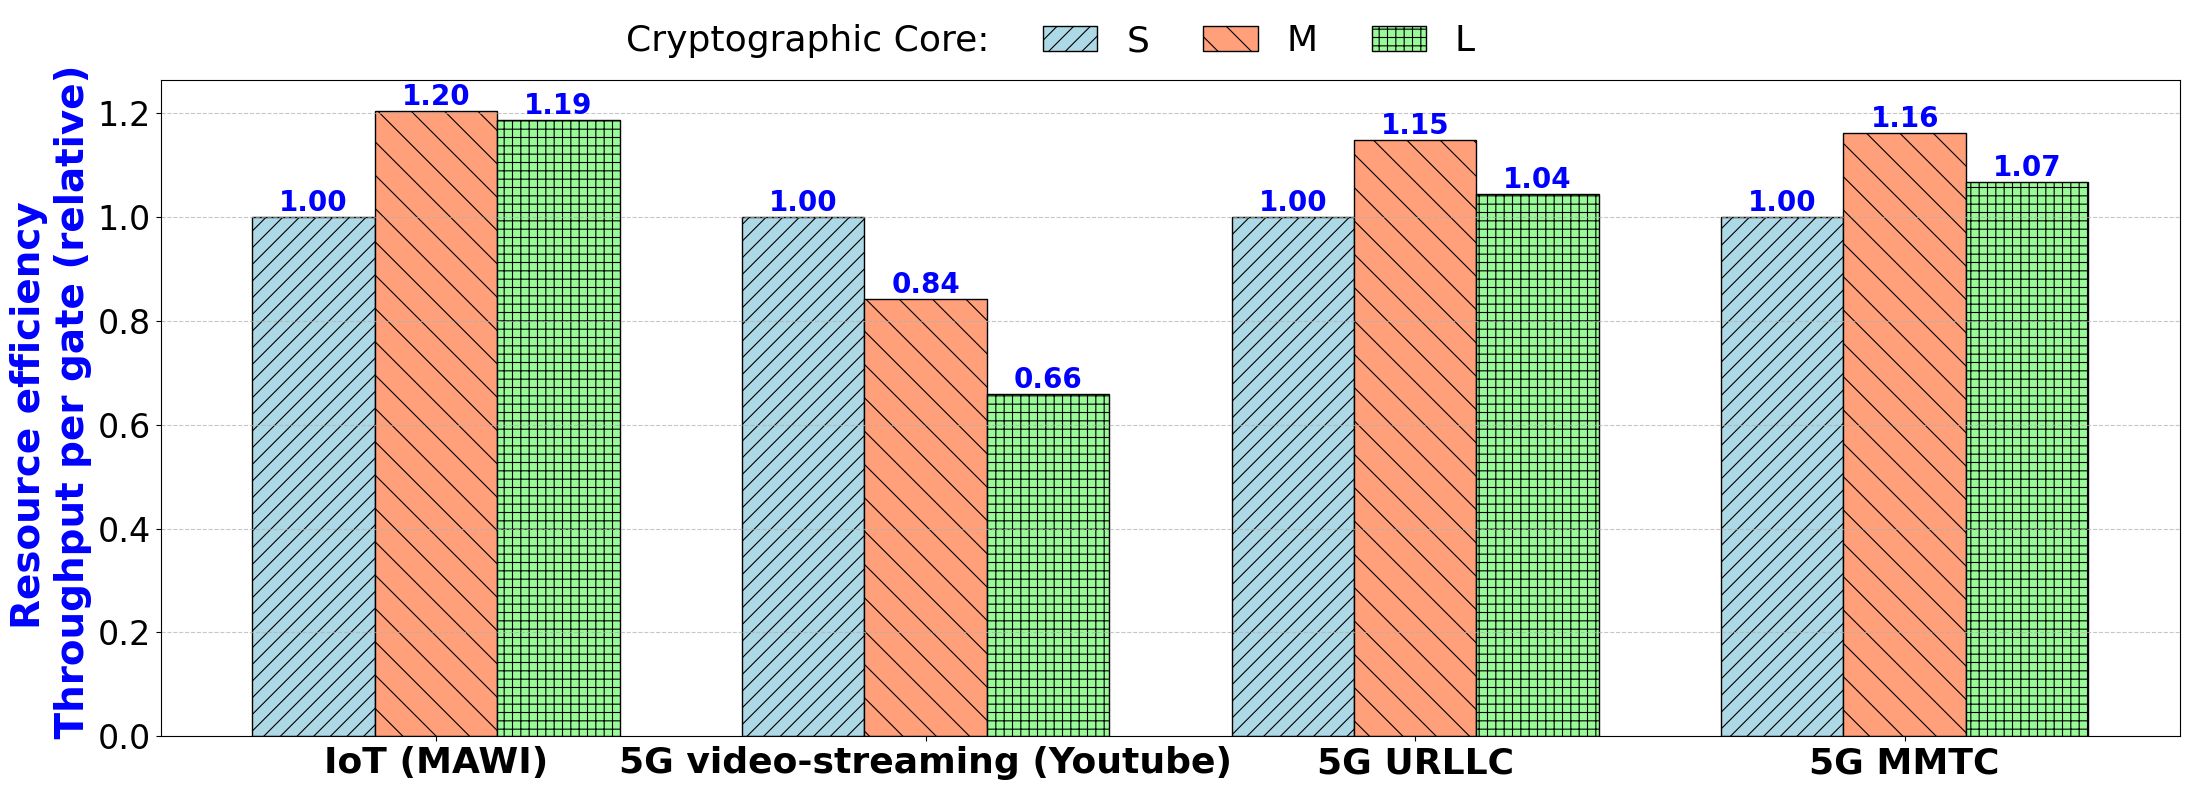

{'1_0_0': 1.0, '3_1_0': 1.162561871011909, '6_2_0': 1.0687775451443042}
{'1_0_0': 1.0, '3_1_0': 1.3349053238131805, '6_2_0': 1.52711842322168}


In [8]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch


# ----- 1. Core‑specific gate‑equivalent and power numbers -----
core_info = {
    '1_0': {'GE': 203760.00, 'Power': 4.381},
    '3_1': {'GE': 241710.00, 'Power': 4.526},
    '6_2': {'GE': 309284.00, 'Power': 4.654}
}

# ----- 2. Visual style (taken from the original script) -----
# colors  = ['#F4C7AB', '#BFD8B8', '#D7CFE4']  # pastel palette
# hatches = ['//', '\\', 'xx']
colors = ['lightblue', 'lightsalmon', 'palegreen']
hatches = ['//', '\\', '++']                # distinctive hatch per bar
labels = ['S','M','L']

plt.rcParams['hatch.linewidth'] = 0.8         # subtle hatch density


# ----- 3. Paths -----
CSV_FOLDER   = 'updated_csvs'
OUTPUT_DIR   = os.path.join(CSV_FOLDER, 'crypto_efficiency_plots')
os.makedirs(OUTPUT_DIR, exist_ok=True)



# ----- 4. Helper to aggregate numbers from every CSV -----
def collect_all_metrics():
    """Return 3 nested dicts keyed by  filename ➜ core ➜ metric."""
    resource_eff, power_eff, throughputs = {}, {}, {}
    throughput_ge_dict = {}
    throughput_watt_dict = {}
    processing_data_dict = {}

    csv_files  = glob.glob(os.path.join(CSV_FOLDER, '*.csv'))
    filenames  = [os.path.splitext(os.path.basename(f))[0] for f in csv_files]

    for path, name in zip(csv_files, filenames):
        df          = pd.read_csv(path)

        first_rows = pd.read_csv(path, nrows=2)
        lengths_col = None  # default column name for lengths
        for c in ["Length (Bytes)", "Length (bytes)", "Length"]:
            if c in first_rows.columns:
                lengths_col = c
                break

        total_bits  = df[lengths_col].sum() * 8

        res, pwr, thr, processing_delay_data = {}, {}, {}, {}
        
        
        for core, spec in core_info.items():
            if core not in df.columns:
                continue          # skip if core column absent

            total_latency      = df[core].max() - df['Time'].min()  # Seconds
            latency_list = df[core].tolist()  # List of latencies for each packet
            relative_time_list = df['Time'].tolist()  # List of relative times for each packet
            # Processing delay :
            processing_delay_list = []
            for i in range(0, len(latency_list)):
                processing_delay_list.append(latency_list[i] - relative_time_list[i])

            
            throughput_bits_seconds = total_bits / total_latency * 1000 * 1000 #(Mbit/seconds)

            thr[core] = throughput_bits_seconds
            res[core] = throughput_bits_seconds / spec['GE']
            pwr[core] = throughput_bits_seconds / spec['Power']
            processing_delay_data[core] = processing_delay_list
        

        # ----- normalise efficiencies to the baseline (core 1_0 = 1) -----
        baseline_res = res['1_0']
        baseline_pwr = pwr['1_0']

        # resource_eff[name] = {k: v / baseline_res for k, v in res.items()}
        # power_eff[name]    = {k: v / baseline_pwr for k, v in pwr.items()}
        # throughputs[name]  = thr

        # Change it to kbps
        throughput_ge_dict[name] = {k: v/ baseline_res   for k, v in res.items()}  # kilobits per second
        throughput_watt_dict[name]    = {k: v /baseline_pwr    for k, v in pwr.items()} # Gigabits
        throughputs[name]  = thr
        processing_data_dict[name] = processing_delay_data

        # resource_eff[name] = {k: v for k, v in res.items()}
        # power_eff[name]    = {k: v for k, v in pwr.items()}
        # throughputs[name]  = thr

    # return filenames, resource_eff, power_eff, throughputs
    # return filenames, res, pwr, thr
    return filenames, throughput_ge_dict, throughput_watt_dict, throughputs, processing_data_dict




# ----- 5. Plotting helper -----
def make_grouped_bar(data_dict, filenames, title, ylabel, out_name, annotate=False):
    bar_width     = 0.25
    core_labels   = list(core_info.keys())
    indices       = np.arange(len(filenames))

    plt.figure(figsize=(22, 8))

    x_labels = ['IoT (MAWI)', '5G video-streaming (Youtube)', '5G URLLC', '5G MMTC']
    legends = ['Cryptographic Core:','S', 'M', 'L']

    for i, core in enumerate(core_labels):
        vals = [data_dict[file][core] for file in filenames]
        bars = plt.bar(
            indices + i * bar_width,
            vals,
            bar_width,
            color=colors[i],
            edgecolor='black',
            linewidth=1,
            hatch=hatches[i],
            label=core,
        )
        if annotate:
            for bar in bars:
                height = bar.get_height()
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    f'{height:.2f}',
                    ha='center',
                    va='bottom',
                    fontsize=20,
                    rotation=0,
                    color = 'blue',
                    fontweight='bold'

                )

    # plt.xlabel('5G Datasets',fontsize=20,fontweight='bold')
    plt.ylabel(ylabel, fontsize=28, fontweight='bold', color='blue')
    plt.title(title,fontsize=28)
    plt.xticks(indices + bar_width * (len(core_labels) - 1) / 2,
               x_labels, ha='center', fontsize=26, fontweight='bold')

    legend_elems = [
        Rectangle((0, 0), 1, 1, facecolor=colors[i],
                  edgecolor='black', linewidth=1, alpha=0.8, hatch=hatches[i])
        for i in range(len(labels))
    ]
    # plt.legend(legend_elems, labels, title='Core')
    # plt.legend(
    # legend_elems,
    # labels,
    # title='cryptographic core',
    # fontsize=16,          # size of the legend labels
    # title_fontsize=16     # size of the legend title
    # )
    legend_labels = ['Cryptographic Core:', 'S', 'M', 'L']
    legend_handles = [
        Patch(facecolor='white', edgecolor='white'),  # blank patch for label
        Patch(facecolor=colors[0], edgecolor='black', hatch=hatches[0]),
        Patch(facecolor=colors[1], edgecolor='black', hatch=hatches[1]),
        Patch(facecolor=colors[2], edgecolor='black', hatch=hatches[2]),
    ]

    plt.legend(
        legend_handles,
        legend_labels,
        loc='lower center',
        bbox_to_anchor=(0.42, 1.0),
        ncol=4,
        frameon=False,
        fontsize=26,
        handlelength=1.5,
        columnspacing=1.5,
        borderaxespad=0.2,
    )

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tick_params(axis='y', labelsize=24)
    plt.tight_layout()
    plt.savefig('/home/iiitd/Aditya/Plot_RoccaS/scripts/Mmtc-Dataset-12G/plots_MMTC_RR/Rocca_5G_Datasets_plot.png',dpi=300)
    plt.show()
    plt.savefig(os.path.join(OUTPUT_DIR, out_name), dpi=300)
    plt.close()


# ----- 6. Main -----
if __name__ == '__main__':
    fnames, res_eff, pwr_eff, thr, processing_data_dict = collect_all_metrics()

    print(res_eff)

    make_grouped_bar(res_eff, fnames,
                    #  'Resource Efficiency',
                        None,
                     'Resource efficiency \n Throughput per gate (relative)',
                     'normalized_resource_eff.png',
                     annotate=True)

    # make_grouped_bar(pwr_eff, fnames,
    #                 #  'Power Efficiency',
    #                  None,
    #                  'Power Efficiency',
    #                  'normalized_power_eff.png')

    # make_grouped_bar(thr, fnames,
    #                  'Raw Throughput Comparison',
    #                  'Throughput (bits/ms)',
    #                  'throughput.png')

    # print('Plots saved to:', OUTPUT_DIR)

    # labels = ['1_0_0', '3_1_0', '6_2_0', '1_0_1', '3_1_1', '6_2_1']
    labels = ['1_0_0', '3_1_0', '6_2_0']
    k=0
    z=0
    v=0

    # dataset_choose = ['merged_packets_with_flow', 'clipped_8k_mmtc_avg_854_12G_1.6']
    dataset_choose = ['clipped_8k_mmtc_avg_854_12G_1.6']

    throughput_ge_dict = {}
    throughput_watt_dict = {}
    processing_data = {}

    # for file in fnames:
    #     if file not in dataset_choose:
    #         continue

    #     temp_1 = res_eff[file] # dictionary
    #     for key,value in temp_1.items():
    #         if labels[k] not in throughput_ge_dict:
    #             throughput_ge_dict[labels[k]] = value
    #             k+=1
        
    #     temp2 = pwr_eff[file] # dictionary
    #     for key,value in temp2.items():
    #         if labels[z] not in throughput_watt_dict:
    #             throughput_watt_dict[labels[z]] = value
    #             z+=1
        
    #     temp3 = processing_data_dict[file]
    #     for key, value in temp3.items():
    #         if labels[v] not in processing_data:
    #             processing_data[labels[v]] = value
    #             v+=1

    temp_mmtc = res_eff['clipped_8k_mmtc_avg_854_12G_1.6']
    for key, value in temp_mmtc.items():
        if labels[k] not in throughput_ge_dict:
            throughput_ge_dict[labels[k]] = value
            k += 1
        if labels[z] not in throughput_watt_dict:
            throughput_watt_dict[labels[z]] = pwr_eff['clipped_8k_mmtc_avg_854_12G_1.6'][key]
            z += 1
        if labels[v] not in processing_data:
            processing_data[labels[v]] = processing_data_dict['clipped_8k_mmtc_avg_854_12G_1.6'][key]
            v += 1
    
    print(throughput_ge_dict)
    print(throughput_watt_dict)
    # print(processing_data['1_0_0'])



Redo for Color Codings

{'Mawi-Dataset-1_1010_3.9G': {'1_0': 1.0, '3_1': 1.2039937258790143, '6_2': 1.187588258376422}, 'merged_packets_with_flow': {'1_0': 1.0, '3_1': 0.8429936708732791, '6_2': 0.6588119663458998}, 'clipped_4k_urllc_avg_615_8.83G_1.6': {'1_0': 1.0, '3_1': 1.1480366827134831, '6_2': 1.0449586695893642}, 'clipped_8k_mmtc_avg_854_12G_1.6': {'1_0': 1.0, '3_1': 1.162561871011909, '6_2': 1.0687775451443042}}


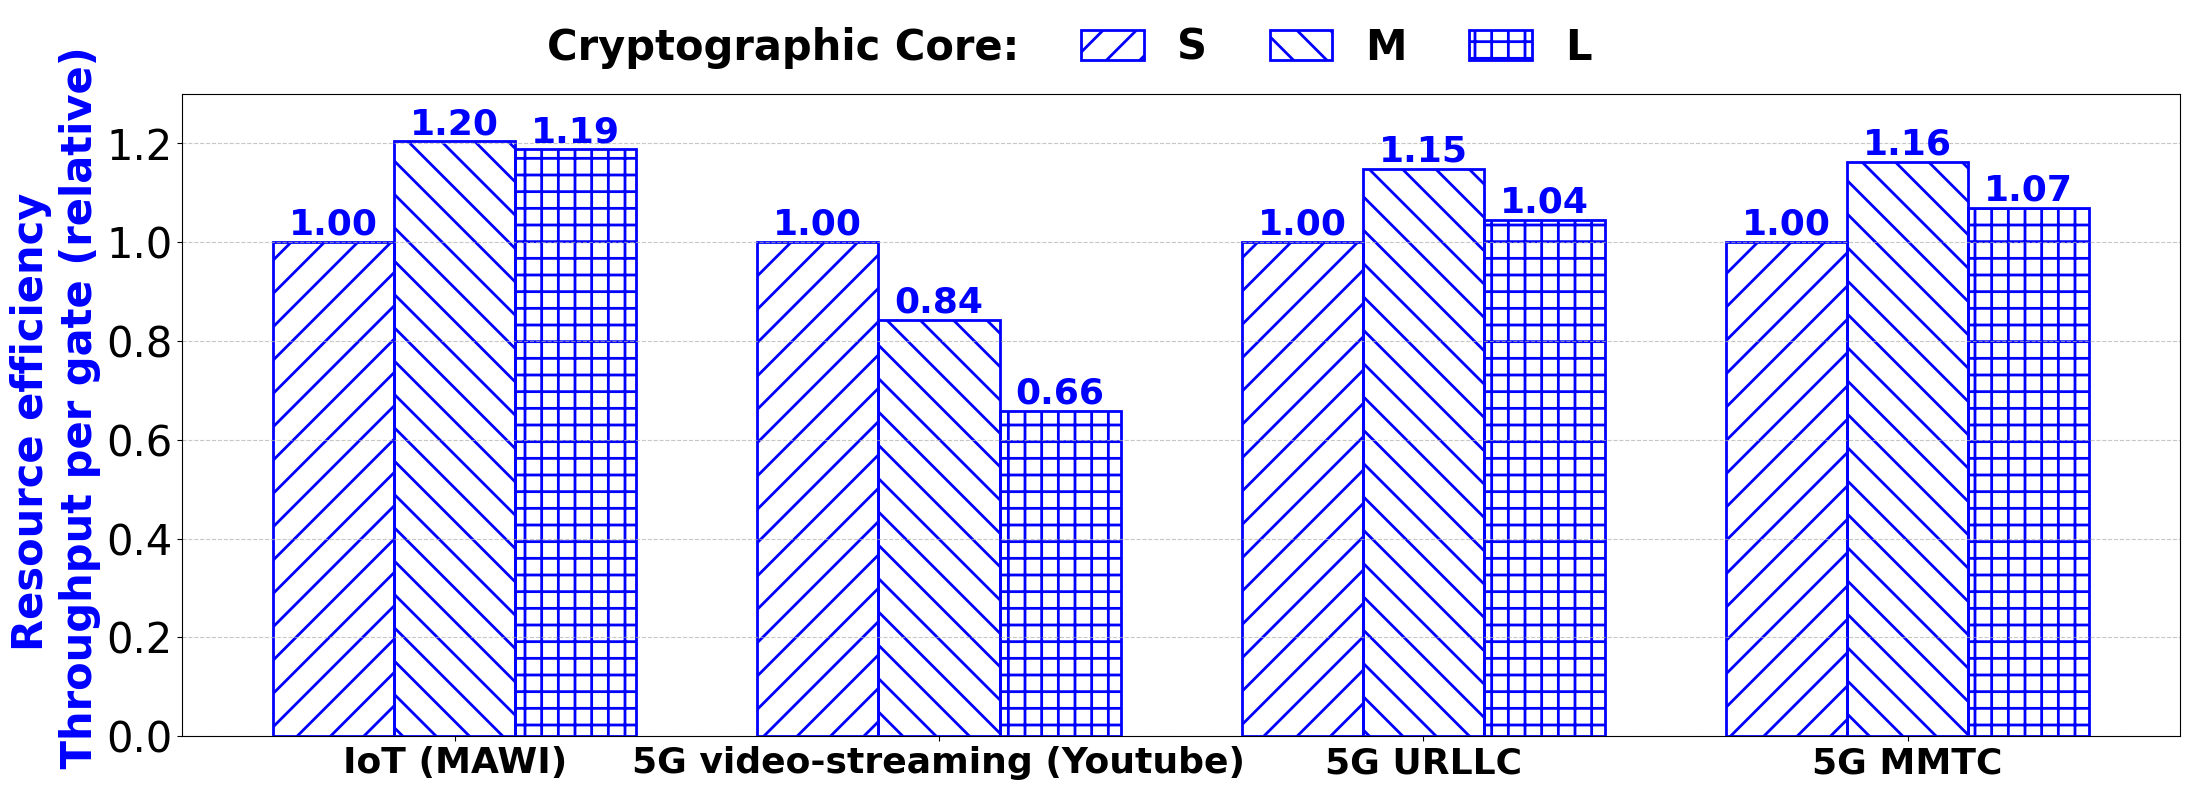

{'1_0_0': 1.0, '3_1_0': 1.162561871011909, '6_2_0': 1.0687775451443042}
{'1_0_0': 1.0, '3_1_0': 1.3349053238131805, '6_2_0': 1.52711842322168}


In [ ]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 2


# ----- 1. Core‑specific gate‑equivalent and power numbers -----
core_info = {
    '1_0': {'GE': 203760.00, 'Power': 4.381},
    '3_1': {'GE': 241710.00, 'Power': 4.526},
    '6_2': {'GE': 309284.00, 'Power': 4.654}
}

# ----- 2. Visual style (taken from the original script) -----
# colors  = ['#F4C7AB', '#BFD8B8', '#D7CFE4']  # pastel palette
# hatches = ['//', '\\', 'xx']
colors = ['lightblue', 'lightsalmon', 'palegreen']
hatches = ['/', '\\', '+']                # distinctive hatch per bar
labels = ['S','M','L']

# plt.rcParams['hatch.linewidth'] = 0.8         # subtle hatch density


# ----- 3. Paths -----
CSV_FOLDER   = 'updated_csvs'
OUTPUT_DIR   = os.path.join(CSV_FOLDER, 'crypto_efficiency_plots')
os.makedirs(OUTPUT_DIR, exist_ok=True)



# ----- 4. Helper to aggregate numbers from every CSV -----
def collect_all_metrics():
    """Return 3 nested dicts keyed by  filename ➜ core ➜ metric."""
    resource_eff, power_eff, throughputs = {}, {}, {}
    throughput_ge_dict = {}
    throughput_watt_dict = {}
    processing_data_dict = {}

    csv_files  = glob.glob(os.path.join(CSV_FOLDER, '*.csv'))
    filenames  = [os.path.splitext(os.path.basename(f))[0] for f in csv_files]

    for path, name in zip(csv_files, filenames):
        df          = pd.read_csv(path)

        first_rows = pd.read_csv(path, nrows=2)
        lengths_col = None  # default column name for lengths
        for c in ["Length (Bytes)", "Length (bytes)", "Length"]:
            if c in first_rows.columns:
                lengths_col = c
                break

        total_bits  = df[lengths_col].sum() * 8

        res, pwr, thr, processing_delay_data = {}, {}, {}, {}
        
        
        for core, spec in core_info.items():
            if core not in df.columns:
                continue          # skip if core column absent

            total_latency      = df[core].max() - df['Time'].min()  # Seconds
            latency_list = df[core].tolist()  # List of latencies for each packet
            relative_time_list = df['Time'].tolist()  # List of relative times for each packet
            # Processing delay :
            processing_delay_list = []
            for i in range(0, len(latency_list)):
                processing_delay_list.append(latency_list[i] - relative_time_list[i])

            
            throughput_bits_seconds = total_bits / total_latency * 1000 * 1000 #(Mbit/seconds)

            thr[core] = throughput_bits_seconds
            res[core] = throughput_bits_seconds / spec['GE']
            pwr[core] = throughput_bits_seconds / spec['Power']
            processing_delay_data[core] = processing_delay_list
        

        # ----- normalise efficiencies to the baseline (core 1_0 = 1) -----
        baseline_res = res['1_0']
        baseline_pwr = pwr['1_0']

        # resource_eff[name] = {k: v / baseline_res for k, v in res.items()}
        # power_eff[name]    = {k: v / baseline_pwr for k, v in pwr.items()}
        # throughputs[name]  = thr

        # Change it to kbps
        throughput_ge_dict[name] = {k: v/ baseline_res   for k, v in res.items()}  # kilobits per second
        throughput_watt_dict[name]    = {k: v /baseline_pwr    for k, v in pwr.items()} # Gigabits
        throughputs[name]  = thr
        processing_data_dict[name] = processing_delay_data

        # resource_eff[name] = {k: v for k, v in res.items()}
        # power_eff[name]    = {k: v for k, v in pwr.items()}
        # throughputs[name]  = thr

    # return filenames, resource_eff, power_eff, throughputs
    # return filenames, res, pwr, thr
    return filenames, throughput_ge_dict, throughput_watt_dict, throughputs, processing_data_dict




# ----- 5. Plotting helper -----
def make_grouped_bar(data_dict, filenames, title, ylabel, out_name, annotate=False):
    bar_width     = 0.25
    core_labels   = list(core_info.keys())
    indices       = np.arange(len(filenames))

    plt.figure(figsize=(22, 8))

    x_labels = ['IoT (MAWI)', '5G video-streaming (Youtube)', '5G URLLC', '5G MMTC']
    legends = ['Cryptographic Core:','S', 'M', 'L']

    for i, core in enumerate(core_labels):
        vals = [data_dict[file][core] for file in filenames]
        bars = plt.bar(
            indices + i * bar_width,
            vals,
            bar_width,
            color=colors[i],
            edgecolor='royalblue',
            linewidth=2,
            hatch=hatches[i],
            label=core,
            fill=False,
        )
        if annotate:
            for bar in bars:
                height = bar.get_height()
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    f'{height:.2f}',
                    ha='center',
                    va='bottom',
                    fontsize=26,
                    rotation=0,
                    color = 'blue',
                    fontweight='bold'

                )

    # plt.xlabel('5G Datasets',fontsize=20,fontweight='bold')
    plt.ylabel(ylabel, fontsize=30, fontweight='bold', color='blue')
    plt.title(title,fontsize=30)
    plt.xticks(indices + bar_width * (len(core_labels) - 1) / 2,
               x_labels, ha='center', fontsize=26, fontweight='bold')
    plt.yticks(fontsize=28)
    plt.ylim(0,1.30)

    legend_elems = [
        Rectangle((0, 0), 1, 1, facecolor=colors[i],
                  edgecolor='blue', linewidth=2, alpha=0.8, hatch=hatches[i], fill=False)
        for i in range(len(labels))
    ]
    # plt.legend(legend_elems, labels, title='Core')
    # plt.legend(
    # legend_elems,
    # labels,
    # title='cryptographic core',
    # fontsize=16,          # size of the legend labels
    # title_fontsize=16     # size of the legend title
    # )
    legend_labels = ['Cryptographic Core:', 'S', 'M', 'L']
    legend_handles = [
        Patch(facecolor='white', edgecolor='white'),  # blank patch for label
        Patch(facecolor=colors[0], edgecolor='blue', hatch=hatches[0], fill=False, linewidth=2),
        Patch(facecolor=colors[1], edgecolor='blue', hatch=hatches[1], fill=False, linewidth=2),
        Patch(facecolor=colors[2], edgecolor='blue', hatch=hatches[2], fill= False, linewidth=2),
    ]

    plt.legend(
        legend_handles,
        legend_labels,
        loc='lower center',
        bbox_to_anchor=(0.42, 1.0),
        ncol=4,
        frameon=False,
        fontsize=30,
        prop={'size': 30, 'weight': 'bold'},
        handlelength=1.5,
        columnspacing=1.5,
        borderaxespad=0.2,
    )

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tick_params(axis='y', labelsize=30)
    plt.tight_layout()
    plt.savefig('/home/iiitd/Aditya/Plot_RoccaS/scripts/Mmtc-Dataset-12G/plots_MMTC_RR/Rocca_5G_Datasets_plot_update.pdf',dpi=300)
    plt.show()
    plt.savefig(os.path.join(OUTPUT_DIR, out_name), dpi=300)
    plt.close()


# ----- 6. Main -----
if __name__ == '__main__':
    fnames, res_eff, pwr_eff, thr, processing_data_dict = collect_all_metrics()

    print(res_eff)

    make_grouped_bar(res_eff, fnames,
                    #  'Resource Efficiency',
                        None,
                     'Resource efficiency \n Throughput per gate (relative)',
                     'normalized_resource_eff.png',
                     annotate=True)

    # make_grouped_bar(pwr_eff, fnames,
    #                 #  'Power Efficiency',
    #                  None,
    #                  'Power Efficiency',
    #                  'normalized_power_eff.png')

    # make_grouped_bar(thr, fnames,
    #                  'Raw Throughput Comparison',
    #                  'Throughput (bits/ms)',
    #                  'throughput.png')

    # print('Plots saved to:', OUTPUT_DIR)

    # labels = ['1_0_0', '3_1_0', '6_2_0', '1_0_1', '3_1_1', '6_2_1']
    labels = ['1_0_0', '3_1_0', '6_2_0']
    k=0
    z=0
    v=0

    # dataset_choose = ['merged_packets_with_flow', 'clipped_8k_mmtc_avg_854_12G_1.6']
    dataset_choose = ['clipped_8k_mmtc_avg_854_12G_1.6']

    throughput_ge_dict = {}
    throughput_watt_dict = {}
    processing_data = {}

    # for file in fnames:
    #     if file not in dataset_choose:
    #         continue

    #     temp_1 = res_eff[file] # dictionary
    #     for key,value in temp_1.items():
    #         if labels[k] not in throughput_ge_dict:
    #             throughput_ge_dict[labels[k]] = value
    #             k+=1
        
    #     temp2 = pwr_eff[file] # dictionary
    #     for key,value in temp2.items():
    #         if labels[z] not in throughput_watt_dict:
    #             throughput_watt_dict[labels[z]] = value
    #             z+=1
        
    #     temp3 = processing_data_dict[file]
    #     for key, value in temp3.items():
    #         if labels[v] not in processing_data:
    #             processing_data[labels[v]] = value
    #             v+=1

    temp_mmtc = res_eff['clipped_8k_mmtc_avg_854_12G_1.6']
    for key, value in temp_mmtc.items():
        if labels[k] not in throughput_ge_dict:
            throughput_ge_dict[labels[k]] = value
            k += 1
        if labels[z] not in throughput_watt_dict:
            throughput_watt_dict[labels[z]] = pwr_eff['clipped_8k_mmtc_avg_854_12G_1.6'][key]
            z += 1
        if labels[v] not in processing_data:
            processing_data[labels[v]] = processing_data_dict['clipped_8k_mmtc_avg_854_12G_1.6'][key]
            v += 1
    
    print(throughput_ge_dict)
    print(throughput_watt_dict)
    # print(processing_data['1_0_0'])



{'Mawi-Dataset-1_1010_3.9G': {'1_0': 1.0, '3_1': 1.2039937258790143, '6_2': 1.187588258376422}, 'merged_packets_with_flow': {'1_0': 1.0, '3_1': 0.8429936708732791, '6_2': 0.6588119663458998}, 'clipped_4k_urllc_avg_615_8.83G_1.6': {'1_0': 1.0, '3_1': 1.1480366827134831, '6_2': 1.0449586695893642}, 'clipped_8k_mmtc_avg_854_12G_1.6': {'1_0': 1.0, '3_1': 1.162561871011909, '6_2': 1.0687775451443042}}


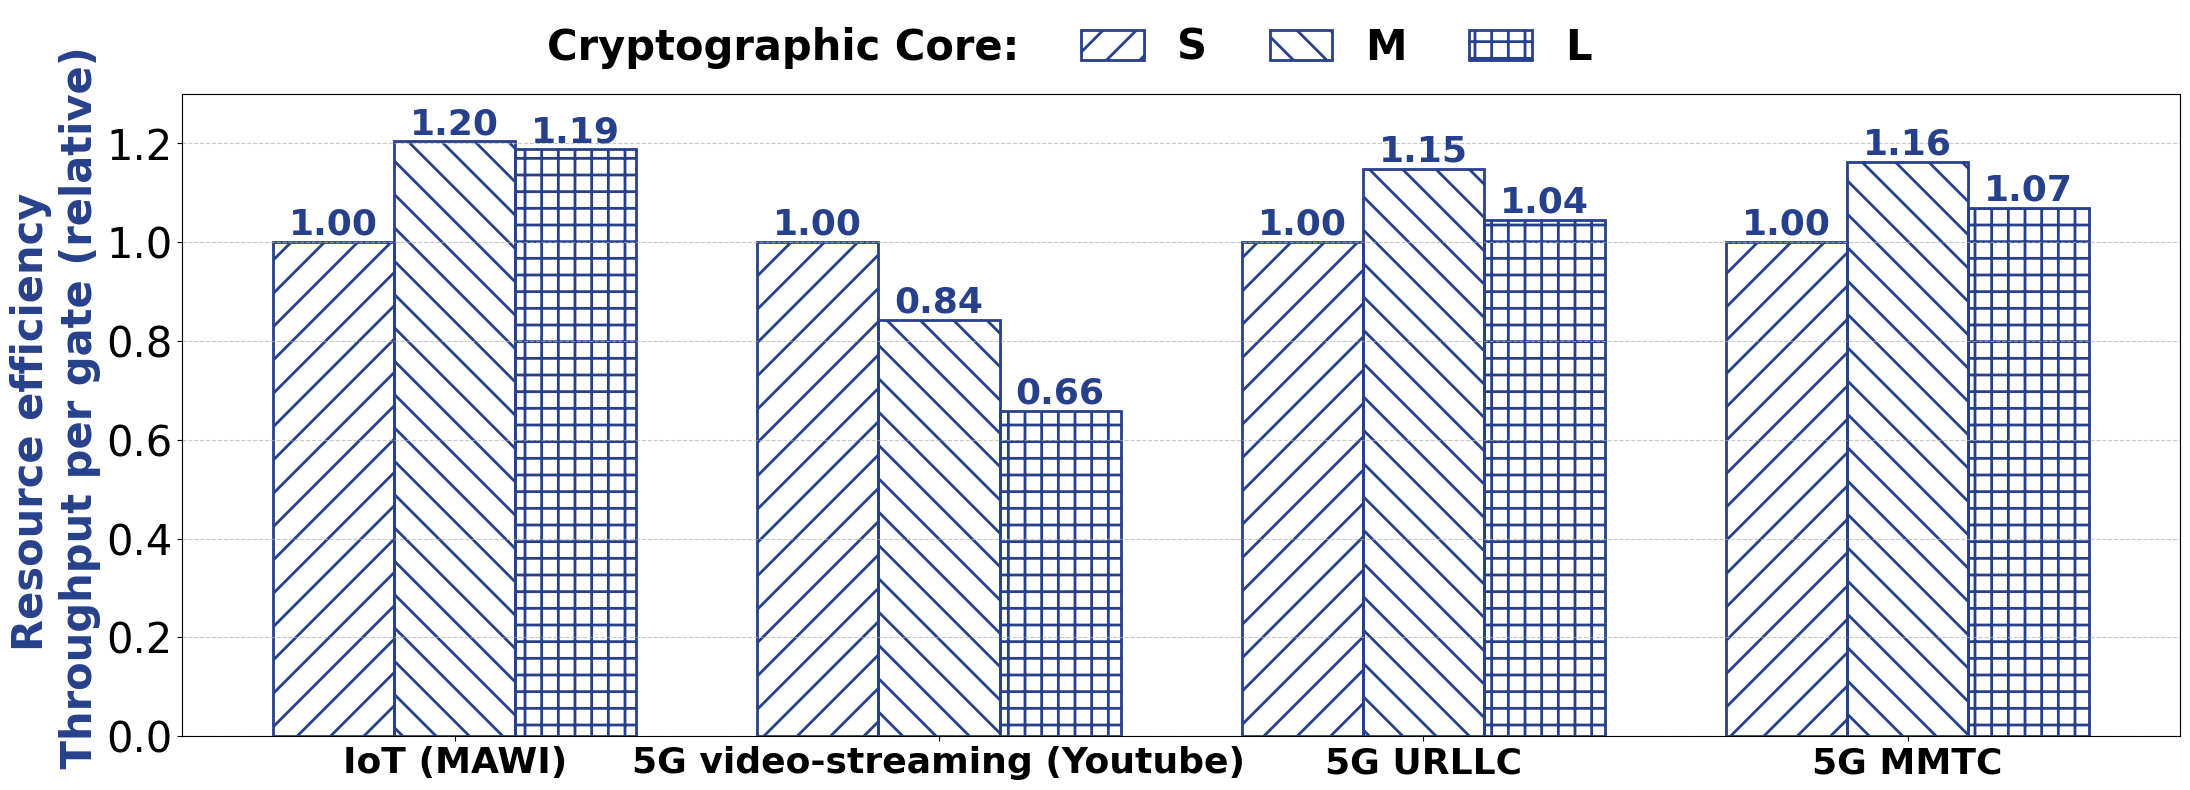

{'1_0_0': 1.0, '3_1_0': 1.162561871011909, '6_2_0': 1.0687775451443042}
{'1_0_0': 1.0, '3_1_0': 1.3349053238131805, '6_2_0': 1.52711842322168}


In [4]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 2


# ----- 1. Core‑specific gate‑equivalent and power numbers -----
core_info = {
    '1_0': {'GE': 203760.00, 'Power': 4.381},
    '3_1': {'GE': 241710.00, 'Power': 4.526},
    '6_2': {'GE': 309284.00, 'Power': 4.654}
}

# ----- 2. Visual style (taken from the original script) -----
# colors  = ['#F4C7AB', '#BFD8B8', '#D7CFE4']  # pastel palette
# hatches = ['//', '\\', 'xx']
colors = ['lightblue', 'lightsalmon', 'palegreen']
hatches = ['/', '\\', '+']                # distinctive hatch per bar
labels = ['S','M','L']

# plt.rcParams['hatch.linewidth'] = 0.8         # subtle hatch density


# ----- 3. Paths -----
CSV_FOLDER   = 'updated_csvs'
OUTPUT_DIR   = os.path.join(CSV_FOLDER, 'crypto_efficiency_plots')
os.makedirs(OUTPUT_DIR, exist_ok=True)



# ----- 4. Helper to aggregate numbers from every CSV -----
def collect_all_metrics():
    """Return 3 nested dicts keyed by  filename ➜ core ➜ metric."""
    resource_eff, power_eff, throughputs = {}, {}, {}
    throughput_ge_dict = {}
    throughput_watt_dict = {}
    processing_data_dict = {}

    csv_files  = glob.glob(os.path.join(CSV_FOLDER, '*.csv'))
    filenames  = [os.path.splitext(os.path.basename(f))[0] for f in csv_files]

    for path, name in zip(csv_files, filenames):
        df          = pd.read_csv(path)

        first_rows = pd.read_csv(path, nrows=2)
        lengths_col = None  # default column name for lengths
        for c in ["Length (Bytes)", "Length (bytes)", "Length"]:
            if c in first_rows.columns:
                lengths_col = c
                break

        total_bits  = df[lengths_col].sum() * 8

        res, pwr, thr, processing_delay_data = {}, {}, {}, {}
        
        
        for core, spec in core_info.items():
            if core not in df.columns:
                continue          # skip if core column absent

            total_latency      = df[core].max() - df['Time'].min()  # Seconds
            latency_list = df[core].tolist()  # List of latencies for each packet
            relative_time_list = df['Time'].tolist()  # List of relative times for each packet
            # Processing delay :
            processing_delay_list = []
            for i in range(0, len(latency_list)):
                processing_delay_list.append(latency_list[i] - relative_time_list[i])

            
            throughput_bits_seconds = total_bits / total_latency * 1000 * 1000 #(Mbit/seconds)

            thr[core] = throughput_bits_seconds
            res[core] = throughput_bits_seconds / spec['GE']
            pwr[core] = throughput_bits_seconds / spec['Power']
            processing_delay_data[core] = processing_delay_list
        

        # ----- normalise efficiencies to the baseline (core 1_0 = 1) -----
        baseline_res = res['1_0']
        baseline_pwr = pwr['1_0']

        # resource_eff[name] = {k: v / baseline_res for k, v in res.items()}
        # power_eff[name]    = {k: v / baseline_pwr for k, v in pwr.items()}
        # throughputs[name]  = thr

        # Change it to kbps
        throughput_ge_dict[name] = {k: v/ baseline_res   for k, v in res.items()}  # kilobits per second
        throughput_watt_dict[name]    = {k: v /baseline_pwr    for k, v in pwr.items()} # Gigabits
        throughputs[name]  = thr
        processing_data_dict[name] = processing_delay_data

        # resource_eff[name] = {k: v for k, v in res.items()}
        # power_eff[name]    = {k: v for k, v in pwr.items()}
        # throughputs[name]  = thr

    # return filenames, resource_eff, power_eff, throughputs
    # return filenames, res, pwr, thr
    return filenames, throughput_ge_dict, throughput_watt_dict, throughputs, processing_data_dict




# ----- 5. Plotting helper -----
def make_grouped_bar(data_dict, filenames, title, ylabel, out_name, annotate=False):
    bar_width     = 0.25
    core_labels   = list(core_info.keys())
    indices       = np.arange(len(filenames))

    plt.figure(figsize=(22, 8))

    x_labels = ['IoT (MAWI)', '5G video-streaming (Youtube)', '5G URLLC', '5G MMTC']
    legends = ['Cryptographic Core:','S', 'M', 'L']

    for i, core in enumerate(core_labels):
        vals = [data_dict[file][core] for file in filenames]
        bars = plt.bar(
            indices + i * bar_width,
            vals,
            bar_width,
            color=colors[i],
            edgecolor="#27408B",
            linewidth=2,
            hatch=hatches[i],
            label=core,
            fill=False,
        )
        if annotate:
            for bar in bars:
                height = bar.get_height()
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    f'{height:.2f}',
                    ha='center',
                    va='bottom',
                    fontsize=26,
                    rotation=0,
                    color = "#27408B",
                    fontweight='bold'

                )

    # plt.xlabel('5G Datasets',fontsize=20,fontweight='bold')
    plt.ylabel(ylabel, fontsize=30, fontweight='bold', color="#27408B")
    plt.title(title,fontsize=30)
    plt.xticks(indices + bar_width * (len(core_labels) - 1) / 2,
               x_labels, ha='center', fontsize=26, fontweight='bold')
    plt.yticks(fontsize=28)
    plt.ylim(0,1.30)

    legend_elems = [
        Rectangle((0, 0), 1, 1, facecolor=colors[i],
                  edgecolor="#27408B", linewidth=2, alpha=0.8, hatch=hatches[i], fill=False)
        for i in range(len(labels))
    ]
    # plt.legend(legend_elems, labels, title='Core')
    # plt.legend(
    # legend_elems,
    # labels,
    # title='cryptographic core',
    # fontsize=16,          # size of the legend labels
    # title_fontsize=16     # size of the legend title
    # )
    legend_labels = ['Cryptographic Core:', 'S', 'M', 'L']
    legend_handles = [
        Patch(facecolor='white', edgecolor='white'),  # blank patch for label
        Patch(facecolor=colors[0], edgecolor="#27408B", hatch=hatches[0], fill=False, linewidth=2),
        Patch(facecolor=colors[1], edgecolor="#27408B", hatch=hatches[1], fill=False, linewidth=2),
        Patch(facecolor=colors[2], edgecolor="#27408B", hatch=hatches[2], fill= False, linewidth=2),
    ]

    plt.legend(
        legend_handles,
        legend_labels,
        loc='lower center',
        bbox_to_anchor=(0.42, 1.0),
        ncol=4,
        frameon=False,
        fontsize=30,
        prop={'size': 30, 'weight': 'bold'},
        handlelength=1.5,
        columnspacing=1.5,
        borderaxespad=0.2,
    )

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tick_params(axis='y', labelsize=30)
    plt.tight_layout()
    plt.savefig('/home/iiitd/Aditya/Plot_RoccaS/scripts/Mmtc-Dataset-12G/plots_MMTC_RR/Rocca_5G_Datasets_plot_update.pdf',dpi=300)
    plt.show()
    plt.savefig(os.path.join(OUTPUT_DIR, out_name), dpi=300)
    plt.close()


# ----- 6. Main -----
if __name__ == '__main__':
    fnames, res_eff, pwr_eff, thr, processing_data_dict = collect_all_metrics()

    print(res_eff)

    make_grouped_bar(res_eff, fnames,
                    #  'Resource Efficiency',
                        None,
                     'Resource efficiency \n Throughput per gate (relative)',
                     'normalized_resource_eff.png',
                     annotate=True)

    # make_grouped_bar(pwr_eff, fnames,
    #                 #  'Power Efficiency',
    #                  None,
    #                  'Power Efficiency',
    #                  'normalized_power_eff.png')

    # make_grouped_bar(thr, fnames,
    #                  'Raw Throughput Comparison',
    #                  'Throughput (bits/ms)',
    #                  'throughput.png')

    # print('Plots saved to:', OUTPUT_DIR)

    # labels = ['1_0_0', '3_1_0', '6_2_0', '1_0_1', '3_1_1', '6_2_1']
    labels = ['1_0_0', '3_1_0', '6_2_0']
    k=0
    z=0
    v=0

    # dataset_choose = ['merged_packets_with_flow', 'clipped_8k_mmtc_avg_854_12G_1.6']
    dataset_choose = ['clipped_8k_mmtc_avg_854_12G_1.6']

    throughput_ge_dict = {}
    throughput_watt_dict = {}
    processing_data = {}

    # for file in fnames:
    #     if file not in dataset_choose:
    #         continue

    #     temp_1 = res_eff[file] # dictionary
    #     for key,value in temp_1.items():
    #         if labels[k] not in throughput_ge_dict:
    #             throughput_ge_dict[labels[k]] = value
    #             k+=1
        
    #     temp2 = pwr_eff[file] # dictionary
    #     for key,value in temp2.items():
    #         if labels[z] not in throughput_watt_dict:
    #             throughput_watt_dict[labels[z]] = value
    #             z+=1
        
    #     temp3 = processing_data_dict[file]
    #     for key, value in temp3.items():
    #         if labels[v] not in processing_data:
    #             processing_data[labels[v]] = value
    #             v+=1

    temp_mmtc = res_eff['clipped_8k_mmtc_avg_854_12G_1.6']
    for key, value in temp_mmtc.items():
        if labels[k] not in throughput_ge_dict:
            throughput_ge_dict[labels[k]] = value
            k += 1
        if labels[z] not in throughput_watt_dict:
            throughput_watt_dict[labels[z]] = pwr_eff['clipped_8k_mmtc_avg_854_12G_1.6'][key]
            z += 1
        if labels[v] not in processing_data:
            processing_data[labels[v]] = processing_data_dict['clipped_8k_mmtc_avg_854_12G_1.6'][key]
            v += 1
    
    print(throughput_ge_dict)
    print(throughput_watt_dict)
    # print(processing_data['1_0_0'])



In [ ]:
import csv
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
# core_files = {
#     '1x_1x': '/home/iiitd/Aditya/Plot_RoccaS/Symmetric_Cores/Youtube_Dataset_0.088G/rocca_1x_1x/round_robin_rocca_1x_6x/order_queue_round_robin_rocca_11_12_old.csv',
#     '3x_3x': '/home/iiitd/Aditya/Plot_RoccaS/Symmetric_Cores/Youtube_Dataset_0.088G/rocca_3x_3x/round_robin_rocca_1x_6x/order_queue_round_robin_rocca_11_12_old.csv',
#     '6x_6x': '/home/iiitd/Aditya/Plot_RoccaS/Symmetric_Cores/Youtube_Dataset_0.088G/rocca_6x_6x /round_robin_rocca_1x_6x/order_queue_round_robin_rocca_11_12_old.csv',
#     # '1x_6x_cs': '/home/iiitd/Aditya/Plot_RoccaS/Asymmetric_Cores/Mmtc-Dataset_12G/rocca_1x_6x/classifier_scheduler_rocca_1x_6x/order_queue_classifier_scheduler_rocca_11_14.csv',
#     # '3x_6x_cs': '/home/iiitd/Aditya/Plot_RoccaS/Asymmetric_Cores/Mmtc-Dataset_12G/rocca_3x_6x/classifier_scheduler_rocca_1x_6x/order_queue_classifier_scheduler_rocca_11_14.csv',
#     '1x_6x_amp' : '/home/iiitd/Aditya/Plot_RoccaS/Asymmetric_Cores/Youtube_Dataset_0.088G/rocca_1x_6x/amp_load_balancer_1x_6x/output.csv',
#     '3x_6x_amp': '/home/iiitd/Aditya/Plot_RoccaS/Asymmetric_Cores/Youtube_Dataset_0.088G/rocca_3x_6x/amp_load_balancer_3x_6x/output.csv',
# }

# core_ge = {
#     '1x_1x': 407520.00,
#     '3x_3x': 483420.00,
#     '6x_6x': 618568.00,
#     '1x_6x': 513044.00,
#     '3x_6x': 550994.00,
# }

# core_watt = {
#     '1x_1x': 5.239,
#     '3x_3x': 5.600,
#     '6x_6x': 5.900,
#     '1x_6x': 5.553,
#     '3x_6x': 5.750,
# }

results_ge = []
results_watt = []

throughput_per_ge_kbps_1x_1x=0.0
throughput_per_watt_gbps_1x_1x=0.0

# Process data
for core_config, file_path in core_files.items():
    try:
        df = pd.read_csv(file_path)
        
        total_bits = (df['Length'] * 8).sum()
        start_time = df['Relative Time'].min()
        end_time = df['Processing Time'].max()
        duration = (end_time - start_time) / 1_000_000
        
        throughput_bps = total_bits / duration if duration > 0 else 0
        throughput_kbps = throughput_bps / 1_000
        throughput_gbps = throughput_bps / 1_000_000_000
        

        ge_key = core_config[:5]
        if ge_key in core_ge:
            
            ge = core_ge[ge_key]
            throughput_per_ge_kbps = throughput_kbps / ge
            if core_config == '1x_1x':
                throughput_per_ge_kbps_1x_1x = throughput_per_ge_kbps
                
            results_ge.append((core_config, throughput_gbps, throughput_per_ge_kbps/throughput_per_ge_kbps_1x_1x))
        
        power_key = core_config[:5]
        if power_key in core_watt:
            watt = core_watt[power_key]
            # throughput_per_watt_kbps = throughput_kbps / watt
            # results_watt.append((core_config, throughput_kbps, throughput_per_watt_kbps))
            throughput_per_watt_gbps = throughput_gbps / watt
            
            if core_config == '1x_1x':
                throughput_per_watt_gbps_1x_1x = throughput_per_watt_gbps
            
            results_watt.append((core_config, throughput_kbps, throughput_per_watt_gbps/throughput_per_watt_gbps_1x_1x))
            
    except Exception as e:
        print(f"Error processing {core_config}: {e}")

def packet_latency(df):

    # Calculate packet latency
    # df['processing_delay'] = df['Processing Time'] - df['Relative Time'] # microseconds
    df['processing_delay'] = (df['Processing Time'] - df['Relative Time'])/1000000 # seconds
    return df[['processing_delay']]  # Return only the relevant column


# Convert to DataFrame
results_df_ge = pd.DataFrame(results_ge, columns=['Core Configuration', 'Throughput (Gbps)', 'Throughput per GE (Kbps)'])
results_df_watt = pd.DataFrame(results_watt, columns=['Core Configuration', 'Throughput (Gbps)', 'Throughput per Watt (Kbps)'])

throughput_ge_dict = dict(zip(results_df_ge['Core Configuration'], results_df_ge['Throughput per GE (Kbps)']))
throughput_watt_dict = dict(zip(results_df_watt['Core Configuration'], results_df_watt['Throughput per Watt (Kbps)']))

print(throughput_ge_dict)



if __name__ == "__main__":
    
    # Updated labels for box plots (same as bar charts)
    config_to_label = {
        '(s,S)': r'$\mathbf(S,S)$',
        '(M,M)': r'$\mathbf(M,M)$',
        '(L,L)' : r'$\mathbf(L,L)$',
        '(S,L)' : r'$\mathbf(S,L)$',
        '(M,L)' : r'$\mathbf(M,L)$',
    }
        
        
    # Initialize data containers
    latency_data = []
    
    # Calculate packet latency for each core configuration.
    for core_config, file_path in core_files.items():
        try:
            print("Core Config :",core_config)
            df2 = pd.read_csv(file_path) # Compute latency
            
            # Calculate packet latency
            df2 = packet_latency(df2) # Compute latency
            
            df2['core_type'] = core_config  # Add core type column
            latency_data.append(df2)  # Append to list
            

            # Calculate Out of Order percentage.
            algo = core_config  # Extract algo from the filename

        except Exception as e:
            print(f"Error processing {core_config}: {e}")

    # Capture the Median Latencies.
    relative_median_latencies = []
    
    first_median_latency = 0.0
    for i, df in enumerate(latency_data):
        if i==0:
            first_median_latency = df['processing_delay'].median()
        # print(df['core_type'][i])
        
        print("Median Latency :",df['processing_delay'].median())
        
        print("Relative Median Latency :",df['processing_delay'].median()/first_median_latency)
        relative_median_latencies.append(df['processing_delay'].median()/first_median_latency)


    # Concatenate all results into a single DataFrame for packet latency
    combined_df = pd.concat(latency_data, ignore_index=True)
    # print(combined_df)

{'1x_1x': 1.0, '3x_3x': 0.8429936718622033, '6x_6x': 0.6588119671830154, '1x_6x_amp': 0.7943178362869457, '3x_6x_amp': 0.7396087813145463}
Core Config : 1x_1x
Core Config : 3x_3x
Core Config : 6x_6x
Core Config : 1x_6x_amp
Core Config : 3x_6x_amp
Median Latency : 4.648882422596216e-06
Relative Median Latency : 1.0
Median Latency : 3.1446498222649096e-06
Relative Median Latency : 0.6764313519696951
Median Latency : 2.3475703299045563e-06
Relative Median Latency : 0.5049751997370439
Median Latency : 2.367025999817997e-06
Relative Median Latency : 0.5091602205968692
Median Latency : 2.34757000207901e-06
Relative Median Latency : 0.5049751292199783


NameError: name 'throughput_ge_dict' is not defined

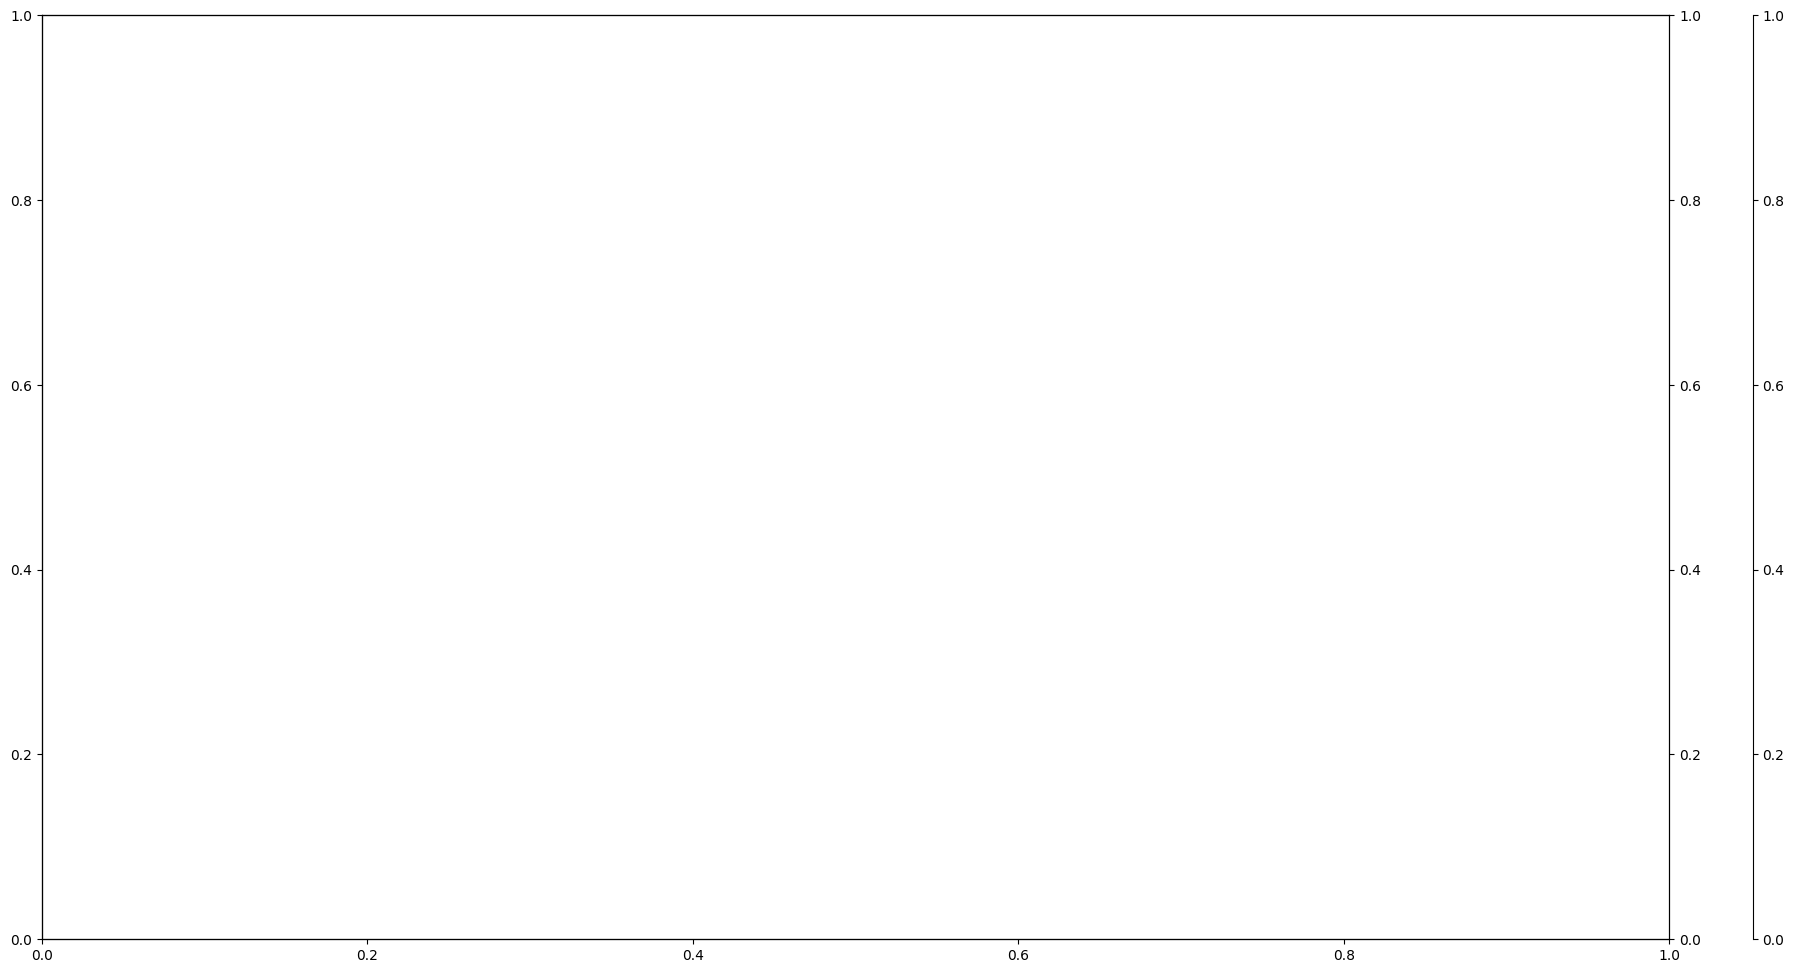

In [ ]:
# print(relative_median_latencies)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

# Prepare data
# core_types = ['1_0_0', '3_1_0', '6_2_0', '1_0_1', '3_1_1', '6_2_1']
core_types = ['1_0_0', '3_1_0', '6_2_0']
label_map = {
    '1_0_0': 'S',
    '3_1_0': 'M',
    '6_2_0': 'L',
    # '1_0_1': 'S',
    # '3_1_1': 'M',
    # '6_2_1': 'L',
}

# Increase spacing between groups - much wider spacing
# x = np.array([0, 2, 4 , 6, 8, 10]) # Consistent spacing of 2 units
x = np.array([0, 2, 4])
bar_width = 0.5  # Slightly wider bars
latency_offset = 0.05

# colors = ['skyblue', 'salmon', 'limegreen', 'orange', 'violet']
# colors = ['lightblue', 'lightsalmon', 'palegreen', 'moccasin', 'plum', 'lightcoral']
colors = ['lightblue', 'lightsalmon', 'palegreen']
hatches = ['///', '\\', '---', '\\\///', '+++','o']

fig, ax1 = plt.subplots(figsize=(21, 12))  # Wider figure to accommodate spacing

# # Right Y-axis for Throughput per Watt
# ax2 = ax1.twinx()

# # Second right Y-axis for Latency
# ax3 = ax1.twinx()


# ax3.spines["right"].set_position(("outward", 60))

# Right Y-axis for Request Latency (closer to the plot)
ax3 = ax1.twinx()

# Second right Y-axis for Throughput per Watt (push it outward)
ax2 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))


# Bar plot: Throughput per GE (left position - more spacing)
bars_ge = []
for i, core in enumerate(core_types):
    val = throughput_ge_dict[core]
    bar = ax1.bar(x[i] - bar_width*1.2, throughput_ge_dict[core], width=bar_width,
                  color=colors[i], hatch=hatches[0], edgecolor='black',
                  alpha=0.8, linewidth=1, label=f"{label_map[core]} - GE")
    bars_ge.append(bar)
    ax1.text(x[i] - bar_width*1.2, val + 0.012 * val, f'{val:.2f}', 
             ha='center', va='bottom', fontsize=24, fontweight='bold', color='blue')

# Bar plot: Throughput per Watt (right position - more spacing)
bars_watt = []
for i, core in enumerate(core_types):
    val = throughput_watt_dict[core]
    print("Throughput per Watt :",val)
    bar = ax3.bar(x[i] + bar_width*1.2, throughput_watt_dict[core], width=bar_width,
                  color=colors[i], hatch=hatches[1], edgecolor='black',
                  alpha=0.8, linewidth=1, label=f"{label_map[core]} - Watt")
    bars_watt.append(bar)
    ax3.text(x[i] + bar_width*1.2, val + 0.011 * val, f'{val:.2f}', 
             ha='center', va='bottom', fontsize=24, fontweight='bold', color='green')

# Box plot: Latency (center position)
# latency_data = [combined_df[combined_df['core_type'] == core]['processing_delay'] for core in core_types]
latency_data = [processing_data[label] for label in core_types]
ooo_offset = bar_width * 0.9
box = ax2.boxplot(latency_data,
                positions=x,
                  widths=bar_width * 0.8,
                  patch_artist=True,
                  showfliers = False,
                  boxprops=dict(facecolor='white', color='black', linewidth=1.5),
                #   boxprops=dict(facecolor='none', edgecolor='g', hatch='xxx', linewidth=1.5),
                  medianprops=dict(color='grey', linewidth=2),
                  whiskerprops=dict(color='grey', linewidth=1.5),
                  capprops=dict(color='grey', linewidth=1.5),
                  flierprops=dict(marker='o', color='red', alpha=0.6, markersize=4))

# bar_latencies = []
# for i, core in enumerate(core_types):
#     val = relative_median_latencies[i]
#     bar = ax2.bar(x[i] , relative_median_latencies[i], width=bar_width,
#                   color=colors[i], hatch=hatches[5], edgecolor='black',
#                   alpha=0.8, linewidth=1, label=f"{label_map[core]} - Watt")
#     bar_latencies.append(bar)
#     ax2.text(x[i] , val + 0.014 * val, f'{val:.1f}', 
#              ha='center', va='bottom', fontsize=23, fontweight='bold', color='red')

# Custom boxplot colors/hatch
for i, patch in enumerate(box['boxes']):
    patch.set_edgecolor('grey')  # Set edge color for the box
    patch.set_facecolor(colors[i])     # No face color fill
    # patch.set_hatch(hatches[i]) # Hatch pattern on edge
    patch.set_hatch('o')   
    patch.set_alpha(1.0)         

# Annotate Median and P99
for i, core in enumerate(core_types):
    lat_vals = processing_data[core]
    if len(lat_vals) > 0:
        latencies_np = np.array(lat_vals)
        mean = np.mean(latencies_np)
        median = np.median(latencies_np)
        # std_dev = np.std(latencies_np)
        # min_val = np.min(latencies_np)
        # max_val = np.max(latencies_np)
        # median = lat_vals.median()
        p99 = np.percentile(lat_vals, 99)
        # Set offset so P99 is slightly above median if they overlap (both are zero or close)
        if abs(p99 - median) < 0.01:  # nearly equal, including both being zero
            p99_y = median + 0.2  # small upward nudge
        else:
            p99_y = p99 + 0.02 * p99  # proportional upward offset

        
        # xpos = x[i] + ooo_offset # Center position for latency annotations
        xpos = x[i]  # Center position for latency annotations
        ax2.text(xpos, median, f'{median:.2f}', ha='center', va='bottom',
                 fontsize=24, fontweight='bold', color='black')
        ax2.text(xpos, p99_y, f'P99: {p99:.2f}', ha='center', va='bottom',
                 fontsize=19, color='red', fontweight='bold')

# for xpos in x[:-1]:
#     ax1.axvline(x=xpos + 0.97, color='gray', linestyle='--', linewidth=1, alpha=0.5)

for xpos in x[:-1]:
    ax1.axvline(x=xpos + 0.97, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Axis Labels
# ax1.set_ylabel('Resource efficiency', fontsize=28, fontweight='bold', color='blue')
ax1.set_ylabel('Resource efficiency\n Throughput per gate (Kbps) ', 
               fontsize=30, fontweight='bold', color='blue')
ax2.set_ylabel('Request latency (seconds)', fontsize=30, fontweight='bold', color='red')
ax3.set_ylabel('Power efficiency \n Throughput per watt (Gbps)', fontsize=30, fontweight='bold', color='green')


# ax1.set_xlabel

# Color-coded ticks
ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')
ax3.tick_params(axis='y', labelcolor='green')

ax1.tick_params(axis='y', labelsize=24)
ax2.tick_params(axis='y', labelsize=24)
ax3.tick_params(axis='y', labelsize=24)

ax1.set_xlabel("Cryptographic Cores (Rocca-S)", fontsize = 30,fontweight='bold')

# X-axis with better spacing
ax1.set_xticks(x)
ax1.set_xticklabels([label_map[c] for c in core_types], fontsize=30, fontweight='bold')

ax1.set_xlim(x[0] - bar_width * 2, x[-1] + bar_width * 2)

# datasets = ['5G video-streaming (Youtube)','5G MMTC']
# for i, name in enumerate(datasets):
#     group_center = i * 3 + 1  # center of each S-M-L group (at index 1 and 4)
#     ax1.text(group_center, ax1.get_ylim()[0] - 0.05 * (ax1.get_ylim()[1] - ax1.get_ylim()[0]),
#             name, ha='center', va='top', fontsize=10)


class CenteredHandler(HandlerPatch):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        center = mpatches.Rectangle(
            (xdescent, ydescent+height/3), width, height + 0.5 ,
            facecolor=orig_handle.get_facecolor(),
            edgecolor=orig_handle.get_edgecolor(),
            hatch=orig_handle.get_hatch(),
            transform=trans
        )
        return [center]


legend_elements = [
    mpatches.Patch(facecolor='white', edgecolor='black', hatch='///', label='Resource efficiency'),
    mpatches.Patch(facecolor='white', edgecolor='black', hatch='o', label='Request latency'),
    mpatches.Patch(facecolor='white', edgecolor='black', hatch='\\', label='Power efficiency'),
]

# Add legend
# ax1.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.12),
#            ncol=3, fontsize=16,  title_fontsize=13, frameon=False)
ax1.legend(handles=legend_elements,
           handler_map={mpatches.Patch: CenteredHandler()},
           loc='upper center', bbox_to_anchor=(0.5, 1.080),
           ncol=3, fontsize=30, frameon=False)

# Remove title and all grids as requested
# plt.title("Performance Comparison of Core Configurations", fontsize=14, fontweight='bold')
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

# Remove legend as requested
# legend_labels = [f"{label_map[c]}" for c in core_types]
# custom_patches = [plt.Rectangle((0, 0), 1, 1, facecolor=colors[i], hatch=hatches[i], edgecolor='black') for i in range(len(core_types))]
# ax1.legend(custom_patches, legend_labels, title="Core Type", loc='upper left', fontsize=10, title_fontsize=11)

# Set x-axis limits to show all data clearly
# ax1.set_xlim(-1, 10)

# Layout
plt.tight_layout()
plt.show()

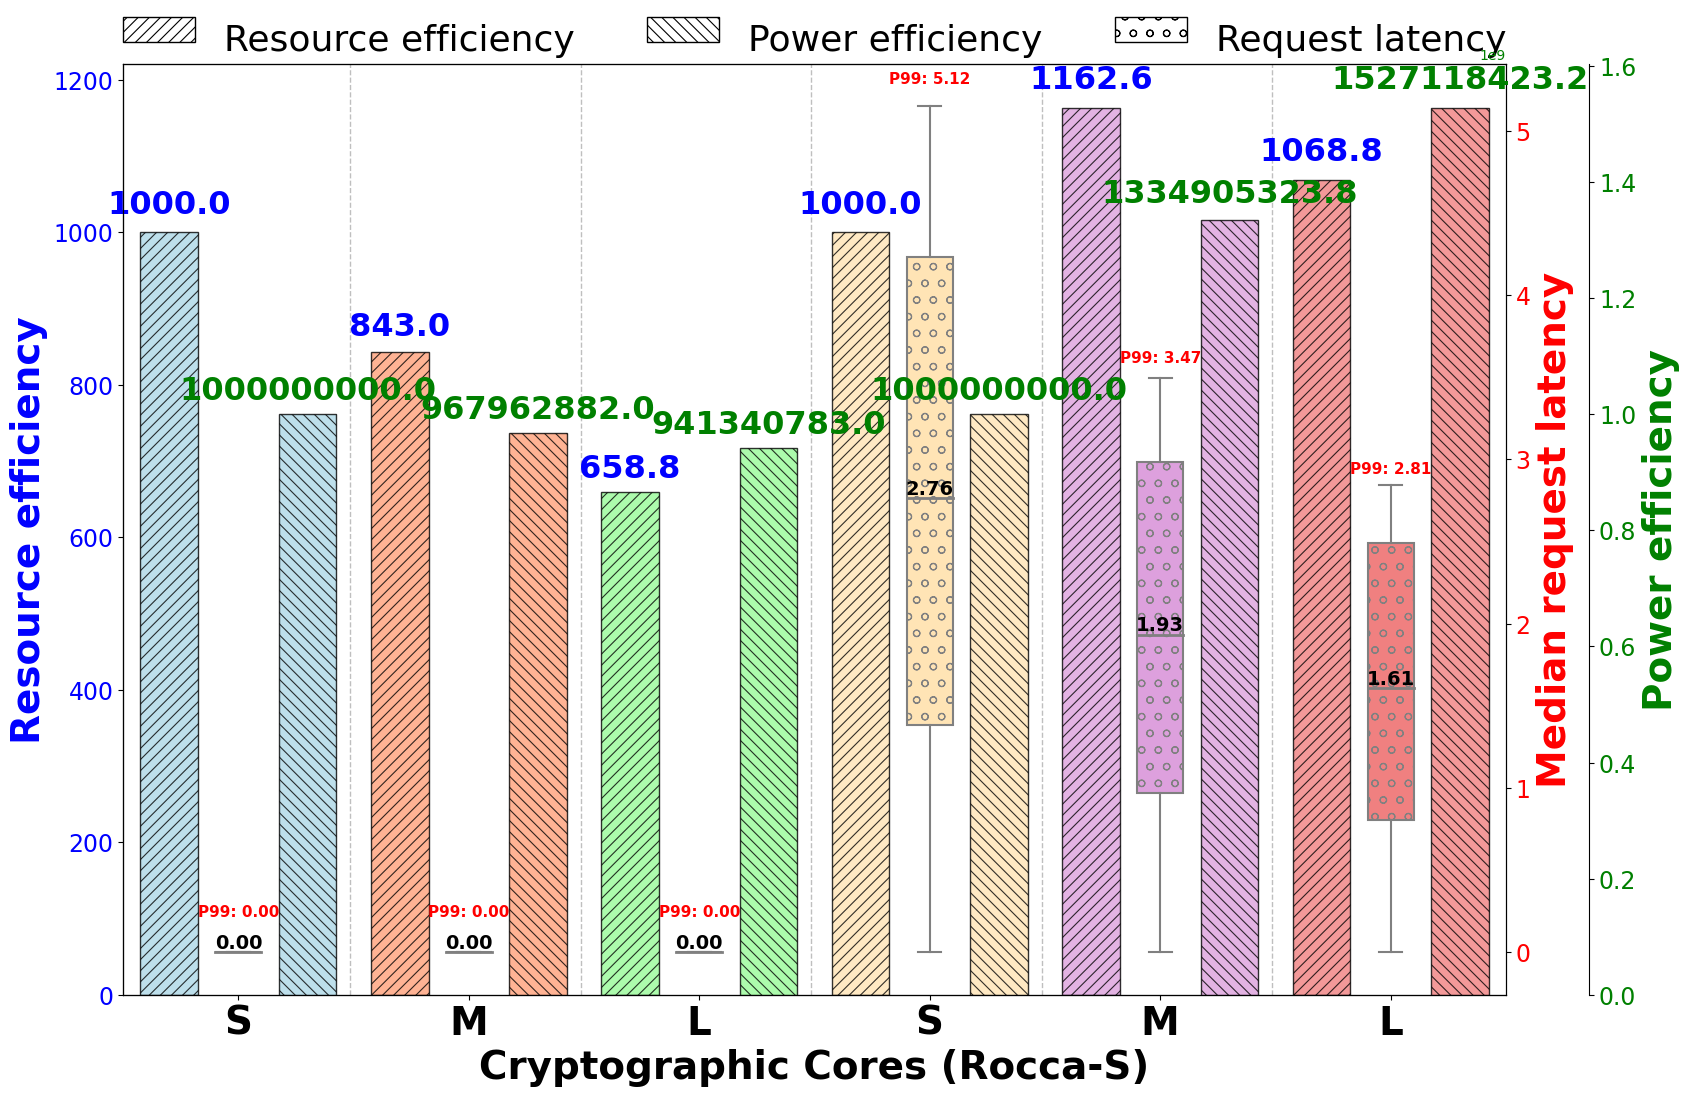

In [69]:
# print(relative_median_latencies)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

# Prepare data
core_types = ['1_0_0', '3_1_0', '6_2_0', '1_0_1', '3_1_1', '6_2_1']
label_map = {
    '1_0_0': 'S',
    '3_1_0': 'M',
    '6_2_0': 'L',
    '1_0_1': 'S',
    '3_1_1': 'M',
    '6_2_1': 'L',
}

# Increase spacing between groups - much wider spacing
x = np.array([0, 2, 4 , 6, 8, 10]) # Consistent spacing of 2 units
bar_width = 0.5  # Slightly wider bars
latency_offset = 0.05

# colors = ['skyblue', 'salmon', 'limegreen', 'orange', 'violet']
colors = ['lightblue', 'lightsalmon', 'palegreen', 'moccasin', 'plum', 'lightcoral']
hatches = ['///', '\\\\\\', '---', '\\\///', '+++','o']

fig, ax1 = plt.subplots(figsize=(17, 11))  # Wider figure to accommodate spacing

# # Right Y-axis for Throughput per Watt
# ax2 = ax1.twinx()

# # Second right Y-axis for Latency
# ax3 = ax1.twinx()


# ax3.spines["right"].set_position(("outward", 60))

# Right Y-axis for Request Latency (closer to the plot)
ax3 = ax1.twinx()

# Second right Y-axis for Throughput per Watt (push it outward)
ax2 = ax1.twinx()
ax2.spines["right"].set_position(("outward", 60))


# Bar plot: Throughput per GE (left position - more spacing)
bars_ge = []
for i, core in enumerate(core_types):
    val = throughput_ge_dict[core]
    bar = ax1.bar(x[i] - bar_width*1.2, throughput_ge_dict[core], width=bar_width,
                  color=colors[i], hatch=hatches[0], edgecolor='black',
                  alpha=0.8, linewidth=1, label=f"{label_map[core]} - GE")
    bars_ge.append(bar)
    ax1.text(x[i] - bar_width*1.2, val + 0.015 * val, f'{val:.1f}', 
             ha='center', va='bottom', fontsize=23, fontweight='bold', color='blue')

# Bar plot: Throughput per Watt (right position - more spacing)
bars_watt = []
for i, core in enumerate(core_types):
    val = throughput_watt_dict[core]
    bar = ax2.bar(x[i] + bar_width*1.2, throughput_watt_dict[core], width=bar_width,
                  color=colors[i], hatch=hatches[1], edgecolor='black',
                  alpha=0.8, linewidth=1, label=f"{label_map[core]} - Watt")
    bars_watt.append(bar)
    ax2.text(x[i] + bar_width*1.2, val + 0.014 * val, f'{val:.1f}', 
             ha='center', va='bottom', fontsize=23, fontweight='bold', color='green')

# Box plot: Latency (center position)
# latency_data = [combined_df[combined_df['core_type'] == core]['processing_delay'] for core in core_types]
latency_data = [processing_data[label] for label in core_types]
ooo_offset = bar_width * 0.9
box = ax3.boxplot(latency_data,
                positions=x,
                  widths=bar_width * 0.8,
                  patch_artist=True,
                  showfliers = False,
                  boxprops=dict(facecolor='white', color='black', linewidth=1.5),
                #   boxprops=dict(facecolor='none', edgecolor='g', hatch='xxx', linewidth=1.5),
                  medianprops=dict(color='grey', linewidth=2),
                  whiskerprops=dict(color='grey', linewidth=1.5),
                  capprops=dict(color='grey', linewidth=1.5),
                  flierprops=dict(marker='o', color='red', alpha=0.6, markersize=4))

# bar_latencies = []
# for i, core in enumerate(core_types):
#     val = relative_median_latencies[i]
#     bar = ax2.bar(x[i] , relative_median_latencies[i], width=bar_width,
#                   color=colors[i], hatch=hatches[5], edgecolor='black',
#                   alpha=0.8, linewidth=1, label=f"{label_map[core]} - Watt")
#     bar_latencies.append(bar)
#     ax2.text(x[i] , val + 0.014 * val, f'{val:.1f}', 
#              ha='center', va='bottom', fontsize=23, fontweight='bold', color='red')

# Custom boxplot colors/hatch
for i, patch in enumerate(box['boxes']):
    patch.set_edgecolor('grey')  # Set edge color for the box
    patch.set_facecolor(colors[i])     # No face color fill
    # patch.set_hatch(hatches[i]) # Hatch pattern on edge
    patch.set_hatch('o')   
    patch.set_alpha(1.0)         

# Annotate Median and P99
for i, core in enumerate(core_types):
    lat_vals = processing_data[core]
    if len(lat_vals) > 0:
        latencies_np = np.array(lat_vals)
        mean = np.mean(latencies_np)
        median = np.median(latencies_np)
        # std_dev = np.std(latencies_np)
        # min_val = np.min(latencies_np)
        # max_val = np.max(latencies_np)
        # median = lat_vals.median()
        p99 = np.percentile(lat_vals, 99)
        # Set offset so P99 is slightly above median if they overlap (both are zero or close)
        if abs(p99 - median) < 0.01:  # nearly equal, including both being zero
            p99_y = median + 0.2  # small upward nudge
        else:
            p99_y = p99 + 0.03 * p99  # proportional upward offset

        
        # xpos = x[i] + ooo_offset # Center position for latency annotations
        xpos = x[i]  # Center position for latency annotations
        ax3.text(xpos, median, f'{median:.2f}', ha='center', va='bottom',
                 fontsize=14, fontweight='bold', color='black')
        ax3.text(xpos, p99_y, f'P99: {p99:.2f}', ha='center', va='bottom',
                 fontsize=11, color='red', fontweight='bold')

# for xpos in x[:-1]:
#     ax1.axvline(x=xpos + 0.97, color='gray', linestyle='--', linewidth=1, alpha=0.5)

for xpos in x[:-1]:
    ax1.axvline(x=xpos + 0.97, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Axis Labels
ax1.set_ylabel('Resource efficiency', fontsize=28, fontweight='bold', color='blue')
ax2.set_ylabel('Power efficiency', fontsize=28, fontweight='bold', color='green')
ax3.set_ylabel('Median request latency', fontsize=28, fontweight='bold', color='red')

# ax1.set_xlabel

# Color-coded ticks
ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='green')
ax3.tick_params(axis='y', labelcolor='red')

ax1.tick_params(axis='y', labelsize=17)
ax2.tick_params(axis='y', labelsize=17)
ax3.tick_params(axis='y', labelsize=17)

ax1.set_xlabel("Cryptographic Cores (Rocca-S)", fontsize = 28,fontweight='bold')

# X-axis with better spacing
ax1.set_xticks(x)
ax1.set_xticklabels([label_map[c] for c in core_types], fontsize=28, fontweight='bold')

ax1.set_xlim(x[0] - bar_width * 2, x[-1] + bar_width * 2)

# datasets = ['5G video-streaming (Youtube)','5G MMTC']
# for i, name in enumerate(datasets):
#     group_center = i * 3 + 1  # center of each S-M-L group (at index 1 and 4)
#     ax1.text(group_center, ax1.get_ylim()[0] - 0.05 * (ax1.get_ylim()[1] - ax1.get_ylim()[0]),
#             name, ha='center', va='top', fontsize=10)


class CenteredHandler(HandlerPatch):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        center = mpatches.Rectangle(
            (xdescent, ydescent+height/3), width, height + 0.5 ,
            facecolor=orig_handle.get_facecolor(),
            edgecolor=orig_handle.get_edgecolor(),
            hatch=orig_handle.get_hatch(),
            transform=trans
        )
        return [center]


legend_elements = [
    mpatches.Patch(facecolor='white', edgecolor='black', hatch='///', label='Resource efficiency'),
    mpatches.Patch(facecolor='white', edgecolor='black', hatch='\\\\\\', label='Power efficiency'),
    mpatches.Patch(facecolor='white', edgecolor='black', hatch='o', label='Request latency'),
]

# Add legend
# ax1.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.12),
#            ncol=3, fontsize=16,  title_fontsize=13, frameon=False)
ax1.legend(handles=legend_elements,
           handler_map={mpatches.Patch: CenteredHandler()},
           loc='upper center', bbox_to_anchor=(0.5, 1.078),
           ncol=3, fontsize=26, frameon=False)

# Remove title and all grids as requested
# plt.title("Performance Comparison of Core Configurations", fontsize=14, fontweight='bold')
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

# Remove legend as requested
# legend_labels = [f"{label_map[c]}" for c in core_types]
# custom_patches = [plt.Rectangle((0, 0), 1, 1, facecolor=colors[i], hatch=hatches[i], edgecolor='black') for i in range(len(core_types))]
# ax1.legend(custom_patches, legend_labels, title="Core Type", loc='upper left', fontsize=10, title_fontsize=11)

# Set x-axis limits to show all data clearly
# ax1.set_xlim(-1, 10)

# Layout
plt.tight_layout()
plt.show()